<a href="https://colab.research.google.com/github/kenichinakanishi/tabular_data_tools/blob/main/Optuna_Tabular_Playground_Series_Jan_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade -q
import os
credentials = 
os.environ['KAGGLE_USERNAME']=credentials["username"]
os.environ['KAGGLE_KEY']=credentials["key"]
!kaggle competitions download -c tabular-playground-series-jan-2021 -q
!unzip -qq tabular-playground-series-jan-2021.zip -d tabular-playground-series-jan-2021

In [2]:
!pip install optuna -q

     |████████████████████████████████| 286kB 7.6MB/s 
     |████████████████████████████████| 1.1MB 11.3MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 481kB 25.0MB/s 
     |████████████████████████████████| 112kB 44.0MB/s 
     |████████████████████████████████| 133kB 32.7MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 


# Optuna

### Training Function
https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial

* trial.suggest_categorical : Suggest a value for the categorical parameter. The value is sampled from the choices
* trial.suggest_discrete_uniform: Suggest a value for the discrete parameter. The value is sampled uniformely from the range [low,high], with some step of discretization
* trial.suggest_logunifrom: Suggest a value for the continuous parameter. The value is sampled from the range [low,high) in the log domain.
* trial.suggest_int: Suggest a value for the integer parameter. The value is sampled from the integers in [low,high]

In [3]:
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
input_path = Path('/content/tabular-playground-series-jan-2021')
from scipy import stats


In [4]:
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import optuna
from optuna import Trial, visualization

In [5]:
# Create dataframes
train = pd.read_csv(input_path / 'train.csv', index_col='id')
test = pd.read_csv(input_path / 'test.csv', index_col='id')
# Drop the 0 outliers
train = train[train.target != 0].reset_index(drop=True)
X = train.drop(columns = 'target')
y = train['target']

# Indentify target and feature columns
feature_cols = [col for col in train.columns.tolist() if col not in ['id', 'target']]
target_cols = ['target']

## Optuna - XGBoost

Tuning methodology for sequential gridsearch
* Set an initial set of starting parameters
* Do 10-fold CV
* Use early stopping to halt training in each fold if no improvement after eg  100 rounds, pick hyperparameters to minimize average error over kfolds
* Tune sequentially on groups of hyperparameters that don't interact too much between groups to reduce combinations
* Tune max_depth and min_child_weight
* Tune subsample and colsample_bytree
* Tune alpha, lambda and gamma (regularization)
* Tune learning rate: lower learning rate will need more rounds/n_estimators
* Retrain and evaluate on full dataset with best learning rate and best n_estimators (average stopping point over kfolds)

Here we skip all the first steps using the in-built cross-validation and optuna optimization and just end with 
* Tune learning rate: lower learning rate will need more rounds/n_estimators
* Retrain and evaluate on full dataset with best learning rate and best n_estimators (average stopping point over kfolds)


In [6]:
#==================================================================
#             Optuna - XGBoost - Simple
#==================================================================
# XGBoost inbuilt cross-validation used
# https://github.com/optuna/optuna/blob/master/examples/xgboost_cv.py

CV_RESULT_DIR = "./xgboost_cv_results"


# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    dtrain = xgb.DMatrix(X, label=y)

    param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        'eta': 0.3, # Fix eta for faster hyperparameter search
        "booster": "gbtree", # Only use gradient boosted trees
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["subsample"] = trial.suggest_discrete_uniform("subsample", 0.6,1,0.1)
        param["colsample_bytree"] = trial.suggest_discrete_uniform("colsample_bytree", 0.6,1,0.1)

    print(param)
    xgb_cv_results = xgb.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=100000,
        nfold=5,
        early_stopping_rounds=25,
        seed=2021,
    )

    # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
    trial.set_user_attr("n_estimators", len(xgb_cv_results))

    # Save cross-validation results.
    filepath = os.path.join(CV_RESULT_DIR, "{}.csv".format(trial.number))
    xgb_cv_results.to_csv(filepath, index=False)

    # Extract the best score.
    best_score = xgb_cv_results["test-rmse-mean"].values[-1]
    return best_score

In [7]:
# Create Study
if not os.path.exists(CV_RESULT_DIR):
        os.mkdir(CV_RESULT_DIR)

study = optuna.create_study(direction="minimize", study_name='XGBoost-Optuna')
study.optimize(objective, 
               n_trials=10,
               n_jobs = 1,
               gc_after_trial = True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

[I 2021-01-18 06:34:27,212] A new study created in memory with name: XGBoost-Optuna


{'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'max_depth': 1, 'subsample': 0.9, 'colsample_bytree': 0.9}


[I 2021-01-18 06:56:10,063] Trial 0 finished with value: 0.7093188 and parameters: {'max_depth': 1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7093188.


{'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0}


[I 2021-01-18 07:04:19,274] Trial 1 finished with value: 0.7021858 and parameters: {'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 1 with value: 0.7021858.


{'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 1.0}


[I 2021-01-18 07:13:51,235] Trial 2 finished with value: 0.702347 and parameters: {'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 1.0}. Best is trial 1 with value: 0.7021858.


{'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'max_depth': 6, 'subsample': 0.9, 'colsample_bytree': 0.6}


[I 2021-01-18 07:16:37,024] Trial 3 finished with value: 0.7030566 and parameters: {'max_depth': 6, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.7021858.


{'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'max_depth': 8, 'subsample': 1.0, 'colsample_bytree': 0.8}


[I 2021-01-18 07:19:59,102] Trial 4 finished with value: 0.7044431999999999 and parameters: {'max_depth': 8, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.7021858.


{'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'max_depth': 4, 'subsample': 0.6, 'colsample_bytree': 1.0}


[I 2021-01-18 07:24:46,039] Trial 5 finished with value: 0.7034860000000001 and parameters: {'max_depth': 4, 'subsample': 0.6, 'colsample_bytree': 1.0}. Best is trial 1 with value: 0.7021858.


{'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.8}


[I 2021-01-18 07:27:36,264] Trial 6 finished with value: 0.707711 and parameters: {'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.7021858.


{'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9}


[I 2021-01-18 07:34:01,856] Trial 7 finished with value: 0.7033472 and parameters: {'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.7021858.


{'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'max_depth': 2, 'subsample': 0.6, 'colsample_bytree': 0.6}


[I 2021-01-18 07:41:54,259] Trial 8 finished with value: 0.7040864000000001 and parameters: {'max_depth': 2, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.7021858.


{'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'max_depth': 2, 'subsample': 0.6, 'colsample_bytree': 0.8}


[I 2021-01-18 07:49:36,838] Trial 9 finished with value: 0.7039508000000001 and parameters: {'max_depth': 2, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.7021858.


Number of finished trials:  10
Best trial:
  Value: 0.7021858
  Params: 
    max_depth: 3
    subsample: 1.0
    colsample_bytree: 1.0
  Number of estimators: 325


In [8]:
# History and Vizualization
history = study.trials_dataframe()
history.sort_values(by="value", ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_max_depth,params_subsample,user_attrs_n_estimators,state
1,1,0.702186,2021-01-18 06:56:10.169148,2021-01-18 07:04:19.273704,0 days 00:08:09.104556,1.0,3,1.0,325,COMPLETE
2,2,0.702347,2021-01-18 07:04:19.364168,2021-01-18 07:13:51.235162,0 days 00:09:31.870994,1.0,3,0.9,392,COMPLETE
3,3,0.703057,2021-01-18 07:13:51.325782,2021-01-18 07:16:37.024199,0 days 00:02:45.698417,0.6,6,0.9,63,COMPLETE
7,7,0.703347,2021-01-18 07:27:36.354132,2021-01-18 07:34:01.855628,0 days 00:06:25.501496,0.9,3,0.7,305,COMPLETE
5,5,0.703486,2021-01-18 07:19:59.193061,2021-01-18 07:24:46.039192,0 days 00:04:46.846131,1.0,4,0.6,147,COMPLETE
9,9,0.703951,2021-01-18 07:41:54.348705,2021-01-18 07:49:36.837670,0 days 00:07:42.488965,0.8,2,0.6,544,COMPLETE
8,8,0.704086,2021-01-18 07:34:01.943756,2021-01-18 07:41:54.258786,0 days 00:07:52.315030,0.6,2,0.6,676,COMPLETE
4,4,0.704443,2021-01-18 07:16:37.114742,2021-01-18 07:19:59.101696,0 days 00:03:21.986954,0.8,8,1.0,34,COMPLETE
6,6,0.707711,2021-01-18 07:24:46.130109,2021-01-18 07:27:36.264462,0 days 00:02:50.134353,0.8,9,0.7,22,COMPLETE
0,0,0.709319,2021-01-18 06:34:27.219838,2021-01-18 06:56:10.063566,0 days 00:21:42.843728,0.9,1,0.9,2323,COMPLETE


In [9]:
study.best_params

{'colsample_bytree': 1.0, 'max_depth': 3, 'subsample': 1.0}

In [10]:
visualization.plot_optimization_history(study)

In [11]:
visualization.plot_parallel_coordinate(study)

In [12]:
visualization.plot_param_importances(study)

## XGBoost Extensive Search

In [13]:
#==================================================================
#             Optuna - XGBoost
#==================================================================
# XGBoost inbuilt cross-validation used
# https://github.com/optuna/optuna/blob/master/examples/xgboost_cv.py

CV_RESULT_DIR = "./xgboost_cv_results"


# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    dtrain = xgb.DMatrix(X, label=y)

    param = {
        "verbosity": 1,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        'eta': 0.3,
        "booster": "gbtree", # Only use gradient boosted trees
        #"booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        param["subsample"] = trial.suggest_discrete_uniform("subsample", 0.6,1,0.1)
        param["colsample_bytree"] = trial.suggest_discrete_uniform("colsample_bytree", 0.6,1,0.1)

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)
    print(param)
    xgb_cv_results = xgb.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=10000,
        nfold=5,
        early_stopping_rounds=25,
        seed=2021,
        verbose_eval=10,
    )

    # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
    trial.set_user_attr("n_estimators", len(xgb_cv_results))

    # Save cross-validation results.
    filepath = os.path.join(CV_RESULT_DIR, "{}.csv".format(trial.number))
    xgb_cv_results.to_csv(filepath, index=False)

    # Extract the best score.
    best_score = xgb_cv_results["test-rmse-mean"].values[-1]
    return best_score

In [14]:
# Create Study
if not os.path.exists(CV_RESULT_DIR):
        os.mkdir(CV_RESULT_DIR)

study = optuna.create_study(direction="minimize", study_name='XGBoost-Optuna')
study.optimize(objective, 
               n_trials=50,
               n_jobs = 1,
               gc_after_trial = True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

[I 2021-01-18 07:49:38,630] A new study created in memory with name: XGBoost-Optuna


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 2.274822152342533e-06, 'alpha': 0.040560577256122596, 'max_depth': 4, 'gamma': 6.929105067953865e-05, 'grow_policy': 'lossguide', 'subsample': 1.0, 'colsample_bytree': 0.7}
[0]	train-rmse:5.23498+0.000330718	test-rmse:5.235+0.002023
[10]	train-rmse:0.728574+0.000615835	test-rmse:0.729868+0.0019898
[20]	train-rmse:0.708621+0.000542418	test-rmse:0.711048+0.00198189
[30]	train-rmse:0.70521+0.000551374	test-rmse:0.708804+0.00199292
[40]	train-rmse:0.7027+0.000527152	test-rmse:0.707223+0.00198652
[50]	train-rmse:0.700604+0.000511011	test-rmse:0.706134+0.00203463
[60]	train-rmse:0.698971+0.000624812	test-rmse:0.705368+0.00193421
[70]	train-rmse:0.69737+0.000608402	test-rmse:0.704623+0.00195436
[80]	train-rmse:0.696112+0.000503453	test-rmse:0.70419+0.00201036
[90]	train-rmse:0.69499+0.000534074	test-rmse:0.703916+0.0020146
[100]	train-rmse:0.693883+0.00047019	test-rmse:0.703701+

[I 2021-01-18 07:56:03,340] Trial 0 finished with value: 0.702674 and parameters: {'lambda': 2.274822152342533e-06, 'alpha': 0.040560577256122596, 'max_depth': 4, 'gamma': 6.929105067953865e-05, 'grow_policy': 'lossguide', 'subsample': 1.0, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.702674.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.09489009699667379, 'alpha': 1.5506481191101274e-06, 'max_depth': 4, 'gamma': 1.3081607453783663e-06, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 0.7}
[0]	train-rmse:5.23499+0.000416245	test-rmse:5.23497+0.0019658
[10]	train-rmse:0.728601+0.000340548	test-rmse:0.729815+0.00227254
[20]	train-rmse:0.708669+0.000456812	test-rmse:0.710974+0.00216997
[30]	train-rmse:0.705347+0.000662122	test-rmse:0.708582+0.00202731
[40]	train-rmse:0.702768+0.000621011	test-rmse:0.707064+0.00202642
[50]	train-rmse:0.700822+0.00073701	test-rmse:0.705867+0.00196053
[60]	train-rmse:0.699063+0.000734978	test-rmse:0.704994+0.00199237
[70]	train-rmse:0.697672+0.000834595	test-rmse:0.704451+0.00196862
[80]	train-rmse:0.69637+0.000762634	test-rmse:0.703977+0.00206389
[90]	train-rmse:0.695113+0.000740656	test-rmse:0.703493+0.00207805
[100]	train-rmse:0.693971+0.000803286	test-rms

[I 2021-01-18 08:01:17,363] Trial 1 finished with value: 0.7023452 and parameters: {'lambda': 0.09489009699667379, 'alpha': 1.5506481191101274e-06, 'max_depth': 4, 'gamma': 1.3081607453783663e-06, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.20805244112806345, 'alpha': 0.00012439307710051408, 'max_depth': 2, 'gamma': 0.0774452886433476, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 0.8}
[0]	train-rmse:5.23525+0.000417179	test-rmse:5.23525+0.00196698
[10]	train-rmse:0.736073+0.000528961	test-rmse:0.736407+0.0018983
[20]	train-rmse:0.7175+0.000557289	test-rmse:0.718061+0.00203303
[30]	train-rmse:0.715058+0.000626412	test-rmse:0.715762+0.00200505
[40]	train-rmse:0.713551+0.000584596	test-rmse:0.714411+0.00209753
[50]	train-rmse:0.712195+0.000662803	test-rmse:0.713243+0.00199558
[60]	train-rmse:0.710974+0.000721895	test-rmse:0.712229+0.00191564
[70]	train-rmse:0.710094+0.000727934	test-rmse:0.711563+0.00195273
[80]	train-rmse:0.709339+0.000757662	test-rmse:0.710983+0.00190189
[90]	train-rmse:0.708458+0.000696741	test-rmse:0.710229+0.00195624
[100]	train-rmse:0.707745+0.000641553	test-rmse:0.

[I 2021-01-18 08:12:06,538] Trial 2 finished with value: 0.7031606 and parameters: {'lambda': 0.20805244112806345, 'alpha': 0.00012439307710051408, 'max_depth': 2, 'gamma': 0.0774452886433476, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 4.995299498665659e-05, 'alpha': 1.278638527097877e-07, 'max_depth': 7, 'gamma': 2.545389137885318e-07, 'grow_policy': 'lossguide', 'subsample': 0.8, 'colsample_bytree': 0.7}
[0]	train-rmse:5.23461+0.000480696	test-rmse:5.23471+0.00184663
[10]	train-rmse:0.714995+0.000453555	test-rmse:0.723844+0.00220515
[20]	train-rmse:0.689987+0.000710722	test-rmse:0.705829+0.00207463
[30]	train-rmse:0.683523+0.000770924	test-rmse:0.704948+0.00210384
[40]	train-rmse:0.678287+0.000698196	test-rmse:0.704715+0.00205461
[50]	train-rmse:0.674176+0.000574044	test-rmse:0.704853+0.00201617


[I 2021-01-18 08:14:37,717] Trial 3 finished with value: 0.7046826 and parameters: {'lambda': 4.995299498665659e-05, 'alpha': 1.278638527097877e-07, 'max_depth': 7, 'gamma': 2.545389137885318e-07, 'grow_policy': 'lossguide', 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.0016030422388074446, 'alpha': 0.000592194776991176, 'max_depth': 3, 'gamma': 9.374320825932873e-08, 'grow_policy': 'depthwise', 'subsample': 0.7, 'colsample_bytree': 0.9}
[0]	train-rmse:5.23526+0.00059599	test-rmse:5.23527+0.001911
[10]	train-rmse:0.732152+0.000409157	test-rmse:0.732848+0.00213419
[20]	train-rmse:0.713081+0.000448553	test-rmse:0.714318+0.0021676
[30]	train-rmse:0.71032+0.000332899	test-rmse:0.712034+0.00225014
[40]	train-rmse:0.70828+0.000451513	test-rmse:0.71059+0.00212551
[50]	train-rmse:0.70648+0.000578404	test-rmse:0.709141+0.00200467
[60]	train-rmse:0.705074+0.000626787	test-rmse:0.708122+0.00204405
[70]	train-rmse:0.703857+0.000535175	test-rmse:0.70733+0.00210735
[80]	train-rmse:0.702762+0.000527618	test-rmse:0.706623+0.00212818
[90]	train-rmse:0.701845+0.000597584	test-rmse:0.706149+0.00208491
[100]	train-rmse:0.701114+0.000566252	test-rmse:0.705

[I 2021-01-18 08:19:48,197] Trial 4 finished with value: 0.7035182 and parameters: {'lambda': 0.0016030422388074446, 'alpha': 0.000592194776991176, 'max_depth': 3, 'gamma': 9.374320825932873e-08, 'grow_policy': 'depthwise', 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.02315077042667607, 'alpha': 2.1967108246247852e-08, 'max_depth': 4, 'gamma': 0.0006827550246685821, 'grow_policy': 'lossguide', 'subsample': 0.7, 'colsample_bytree': 0.6}
[0]	train-rmse:5.23518+0.000586855	test-rmse:5.23517+0.00183338
[10]	train-rmse:0.729003+0.0004746	test-rmse:0.73034+0.0021479
[20]	train-rmse:0.708885+0.000660606	test-rmse:0.711186+0.00206378
[30]	train-rmse:0.705609+0.000620354	test-rmse:0.708971+0.00198356
[40]	train-rmse:0.703211+0.000541309	test-rmse:0.707472+0.00203006
[50]	train-rmse:0.701336+0.000538874	test-rmse:0.706456+0.00198935
[60]	train-rmse:0.699541+0.00054878	test-rmse:0.705545+0.00201544
[70]	train-rmse:0.698078+0.000575502	test-rmse:0.704976+0.00202106
[80]	train-rmse:0.696837+0.000532042	test-rmse:0.704634+0.00199003
[90]	train-rmse:0.695634+0.00057148	test-rmse:0.704235+0.00193257
[100]	train-rmse:0.69458+0.000560173	test-rmse:0.7

[I 2021-01-18 08:23:24,493] Trial 5 finished with value: 0.7036568 and parameters: {'lambda': 0.02315077042667607, 'alpha': 2.1967108246247852e-08, 'max_depth': 4, 'gamma': 0.0006827550246685821, 'grow_policy': 'lossguide', 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 3.465597553136426e-07, 'alpha': 9.187924604523806e-08, 'max_depth': 7, 'gamma': 8.095290540890745e-07, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.9}
[0]	train-rmse:5.23444+0.000331614	test-rmse:5.23453+0.00195153
[10]	train-rmse:0.713848+0.00077447	test-rmse:0.723525+0.00196501
[20]	train-rmse:0.688226+0.00090263	test-rmse:0.705301+0.00189834
[30]	train-rmse:0.680904+0.000722805	test-rmse:0.704082+0.00210829
[40]	train-rmse:0.675774+0.00090698	test-rmse:0.703835+0.00209636
[50]	train-rmse:0.671239+0.000971345	test-rmse:0.703981+0.00216233
[60]	train-rmse:0.667696+0.000928552	test-rmse:0.704138+0.00213546


[I 2021-01-18 08:26:47,358] Trial 6 finished with value: 0.7038348 and parameters: {'lambda': 3.465597553136426e-07, 'alpha': 9.187924604523806e-08, 'max_depth': 7, 'gamma': 8.095290540890745e-07, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 4.453215784205913e-07, 'alpha': 2.426739855105138e-06, 'max_depth': 9, 'gamma': 0.00968425066832877, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23392+0.000418712	test-rmse:5.23438+0.00190007
[10]	train-rmse:0.695414+0.00111631	test-rmse:0.723487+0.00204346
[20]	train-rmse:0.661584+0.00141491	test-rmse:0.707718+0.0018159
[30]	train-rmse:0.650122+0.00109124	test-rmse:0.7082+0.00170048
[40]	train-rmse:0.641224+0.00197816	test-rmse:0.709015+0.00169826


[I 2021-01-18 08:30:09,079] Trial 7 finished with value: 0.7076951999999999 and parameters: {'lambda': 4.453215784205913e-07, 'alpha': 2.426739855105138e-06, 'max_depth': 9, 'gamma': 0.00968425066832877, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.0011692902844246864, 'alpha': 0.007078066303757121, 'max_depth': 4, 'gamma': 7.680586551415971e-06, 'grow_policy': 'lossguide', 'subsample': 0.6, 'colsample_bytree': 0.6}
[0]	train-rmse:5.23516+0.000683596	test-rmse:5.23513+0.0017789
[10]	train-rmse:0.728885+0.000411848	test-rmse:0.730146+0.00221735
[20]	train-rmse:0.708775+0.000550098	test-rmse:0.711152+0.00216306
[30]	train-rmse:0.705554+0.000535389	test-rmse:0.709022+0.00221609
[40]	train-rmse:0.70317+0.000584467	test-rmse:0.707481+0.00209947
[50]	train-rmse:0.701256+0.000550246	test-rmse:0.706483+0.00223081
[60]	train-rmse:0.699753+0.000477523	test-rmse:0.705866+0.0023863
[70]	train-rmse:0.698411+0.000510835	test-rmse:0.705425+0.00242558
[80]	train-rmse:0.697197+0.000542211	test-rmse:0.704988+0.00233735
[90]	train-rmse:0.696042+0.000583986	test-rmse:0.704688+0.00229865
[100]	train-rmse:0.694961+0.000497987	test-rmse

[I 2021-01-18 08:33:27,435] Trial 8 finished with value: 0.7040791999999999 and parameters: {'lambda': 0.0011692902844246864, 'alpha': 0.007078066303757121, 'max_depth': 4, 'gamma': 7.680586551415971e-06, 'grow_policy': 'lossguide', 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 7.820762295635174e-05, 'alpha': 1.1944075633377087e-08, 'max_depth': 6, 'gamma': 1.677940060723288e-08, 'grow_policy': 'depthwise', 'subsample': 0.6, 'colsample_bytree': 0.7}
[0]	train-rmse:5.23484+0.000637911	test-rmse:5.2349+0.00183904
[10]	train-rmse:0.720953+0.000384111	test-rmse:0.725729+0.00187952
[20]	train-rmse:0.698774+0.000576701	test-rmse:0.707386+0.00165995
[30]	train-rmse:0.693665+0.000459065	test-rmse:0.705836+0.00191162
[40]	train-rmse:0.689846+0.000544722	test-rmse:0.705391+0.00192053
[50]	train-rmse:0.686853+0.000695161	test-rmse:0.705355+0.00182863
[60]	train-rmse:0.684057+0.000531507	test-rmse:0.705451+0.00176975
[70]	train-rmse:0.6817+0.000725663	test-rmse:0.705657+0.00173931


[I 2021-01-18 08:36:03,125] Trial 9 finished with value: 0.705292 and parameters: {'lambda': 7.820762295635174e-05, 'alpha': 1.1944075633377087e-08, 'max_depth': 6, 'gamma': 1.677940060723288e-08, 'grow_policy': 'depthwise', 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.8918104871817465, 'alpha': 2.5522406568949606e-06, 'max_depth': 2, 'gamma': 5.677143566347854e-06, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 0.8}
[0]	train-rmse:5.23528+0.00041782	test-rmse:5.23528+0.00196687
[10]	train-rmse:0.736026+0.000549742	test-rmse:0.736364+0.00185335
[20]	train-rmse:0.717538+0.000607345	test-rmse:0.71807+0.00198534
[30]	train-rmse:0.715162+0.000546692	test-rmse:0.715829+0.00205195
[40]	train-rmse:0.713522+0.000622683	test-rmse:0.714317+0.00202752
[50]	train-rmse:0.712222+0.000729215	test-rmse:0.713248+0.00196709
[60]	train-rmse:0.711032+0.000698822	test-rmse:0.712242+0.00194203
[70]	train-rmse:0.710111+0.000754161	test-rmse:0.711548+0.00192036
[80]	train-rmse:0.709202+0.000670507	test-rmse:0.71078+0.00191977
[90]	train-rmse:0.708355+0.000636264	test-rmse:0.710051+0.00199796
[100]	train-rmse:0.707662+0.000647845	test-rmse:

[I 2021-01-18 08:46:14,337] Trial 10 finished with value: 0.7032219999999999 and parameters: {'lambda': 0.8918104871817465, 'alpha': 2.5522406568949606e-06, 'max_depth': 2, 'gamma': 5.677143566347854e-06, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 1.7442182735816942e-08, 'alpha': 0.12801359616742458, 'max_depth': 5, 'gamma': 0.0003686900021077532, 'grow_policy': 'lossguide', 'subsample': 1.0, 'colsample_bytree': 0.7}
[0]	train-rmse:5.23484+0.000321352	test-rmse:5.23488+0.00199175
[10]	train-rmse:0.724727+0.00066651	test-rmse:0.727357+0.00187261
[20]	train-rmse:0.703683+0.000301392	test-rmse:0.708481+0.00208055
[30]	train-rmse:0.699423+0.000598457	test-rmse:0.706245+0.00188693
[40]	train-rmse:0.696069+0.000370041	test-rmse:0.704822+0.00196331
[50]	train-rmse:0.693554+0.0004433	test-rmse:0.70397+0.00199048
[60]	train-rmse:0.691472+0.000494898	test-rmse:0.703377+0.00196287
[70]	train-rmse:0.689645+0.000390433	test-rmse:0.703187+0.00198763
[80]	train-rmse:0.687757+0.000449244	test-rmse:0.702897+0.00194072
[90]	train-rmse:0.686141+0.000396041	test-rmse:0.702796+0.00186999
[100]	train-rmse:0.684672+0.000521072	test-rmse:

[I 2021-01-18 08:50:27,283] Trial 11 finished with value: 0.7025653999999999 and parameters: {'lambda': 1.7442182735816942e-08, 'alpha': 0.12801359616742458, 'max_depth': 5, 'gamma': 0.0003686900021077532, 'grow_policy': 'lossguide', 'subsample': 1.0, 'colsample_bytree': 0.7}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 1.0967131057392316e-08, 'alpha': 0.4936526705669946, 'max_depth': 6, 'gamma': 0.00037434727629147535, 'grow_policy': 'lossguide', 'subsample': 1.0, 'colsample_bytree': 0.7}
[0]	train-rmse:5.23474+0.000322035	test-rmse:5.2348+0.00198585
[10]	train-rmse:0.720715+0.000818265	test-rmse:0.725574+0.00179682
[20]	train-rmse:0.69743+0.000708189	test-rmse:0.706305+0.00183569
[30]	train-rmse:0.691843+0.000681534	test-rmse:0.704453+0.00192172
[40]	train-rmse:0.688+0.000655034	test-rmse:0.703694+0.00196251
[50]	train-rmse:0.684577+0.000536707	test-rmse:0.703246+0.00196492
[60]	train-rmse:0.681548+0.000578259	test-rmse:0.702943+0.00200115
[70]	train-rmse:0.678945+0.000458113	test-rmse:0.702893+0.00194527
[80]	train-rmse:0.676409+0.000703411	test-rmse:0.702963+0.0019816


[I 2021-01-18 08:53:44,613] Trial 12 finished with value: 0.7028757999999999 and parameters: {'lambda': 1.0967131057392316e-08, 'alpha': 0.4936526705669946, 'max_depth': 6, 'gamma': 0.00037434727629147535, 'grow_policy': 'lossguide', 'subsample': 1.0, 'colsample_bytree': 0.7}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 1.4968227807756948e-08, 'alpha': 4.511968533486459e-06, 'max_depth': 1, 'gamma': 0.005856438649674297, 'grow_policy': 'lossguide', 'subsample': 0.9, 'colsample_bytree': 0.6}
[0]	train-rmse:5.23535+0.000410654	test-rmse:5.23536+0.00193044
[10]	train-rmse:0.740837+0.00050893	test-rmse:0.740939+0.0018439
[20]	train-rmse:0.723931+0.000512253	test-rmse:0.724108+0.00184041
[30]	train-rmse:0.722358+0.000506951	test-rmse:0.722614+0.00187062
[40]	train-rmse:0.72118+0.000512142	test-rmse:0.721468+0.00186069
[50]	train-rmse:0.720272+0.000512462	test-rmse:0.720644+0.00195915
[60]	train-rmse:0.719504+0.000501184	test-rmse:0.719896+0.00196437
[70]	train-rmse:0.718873+0.000508674	test-rmse:0.719324+0.00196537
[80]	train-rmse:0.718322+0.000521598	test-rmse:0.718817+0.00197062
[90]	train-rmse:0.717845+0.000521605	test-rmse:0.718344+0.00198049
[100]	train-rmse:0.717417+0.000526285	test-rms

[I 2021-01-18 09:12:07,900] Trial 13 finished with value: 0.7093621999999999 and parameters: {'lambda': 1.4968227807756948e-08, 'alpha': 4.511968533486459e-06, 'max_depth': 1, 'gamma': 0.005856438649674297, 'grow_policy': 'lossguide', 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.020361782587298854, 'alpha': 0.7567274859747825, 'max_depth': 5, 'gamma': 1.4911291117311188e-05, 'grow_policy': 'depthwise', 'subsample': 0.8, 'colsample_bytree': 0.8}
[0]	train-rmse:5.23486+0.00048067	test-rmse:5.23489+0.00187778
[10]	train-rmse:0.725006+0.000413705	test-rmse:0.727571+0.00201358
[20]	train-rmse:0.703849+0.000388365	test-rmse:0.708676+0.00202989
[30]	train-rmse:0.699574+0.00048719	test-rmse:0.706308+0.00199383
[40]	train-rmse:0.696262+0.000610124	test-rmse:0.704946+0.00199515
[50]	train-rmse:0.693776+0.000678851	test-rmse:0.704268+0.00211991
[60]	train-rmse:0.691494+0.00065881	test-rmse:0.703652+0.00205519
[70]	train-rmse:0.689567+0.000846138	test-rmse:0.703322+0.00202997
[80]	train-rmse:0.687603+0.000785097	test-rmse:0.703114+0.00215418
[90]	train-rmse:0.685829+0.000746942	test-rmse:0.702987+0.00222184
[100]	train-rmse:0.684211+0.000806438	test-rmse:0

[I 2021-01-18 09:16:22,268] Trial 14 finished with value: 0.7029567999999999 and parameters: {'lambda': 0.020361782587298854, 'alpha': 0.7567274859747825, 'max_depth': 5, 'gamma': 1.4911291117311188e-05, 'grow_policy': 'depthwise', 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 7.644571254138011e-06, 'alpha': 0.0014492821176593832, 'max_depth': 9, 'gamma': 0.28810367134402604, 'grow_policy': 'lossguide', 'subsample': 1.0, 'colsample_bytree': 0.7}
[0]	train-rmse:5.23413+0.000324032	test-rmse:5.23453+0.00207363
[10]	train-rmse:0.696143+0.00119405	test-rmse:0.723091+0.00173424
[20]	train-rmse:0.66233+0.000907743	test-rmse:0.706401+0.00177415
[30]	train-rmse:0.651409+0.000854375	test-rmse:0.706596+0.00189665
[40]	train-rmse:0.642529+0.00126101	test-rmse:0.707372+0.00190843


[I 2021-01-18 09:19:07,623] Trial 15 finished with value: 0.7063149999999999 and parameters: {'lambda': 7.644571254138011e-06, 'alpha': 0.0014492821176593832, 'max_depth': 9, 'gamma': 0.28810367134402604, 'grow_policy': 'lossguide', 'subsample': 1.0, 'colsample_bytree': 0.7}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.0020172384610427875, 'alpha': 1.9888298033692096e-05, 'max_depth': 5, 'gamma': 8.990624506896546e-05, 'grow_policy': 'lossguide', 'subsample': 0.9, 'colsample_bytree': 0.6}
[0]	train-rmse:5.23481+0.000413864	test-rmse:5.23485+0.00195562
[10]	train-rmse:0.725114+0.000393202	test-rmse:0.727717+0.0020973
[20]	train-rmse:0.703843+0.000356324	test-rmse:0.708613+0.00216911
[30]	train-rmse:0.699634+0.000431443	test-rmse:0.706447+0.00210152
[40]	train-rmse:0.696626+0.000615752	test-rmse:0.705176+0.00182915
[50]	train-rmse:0.69419+0.000610775	test-rmse:0.704337+0.00178203
[60]	train-rmse:0.691902+0.000834168	test-rmse:0.703779+0.00167463
[70]	train-rmse:0.690067+0.00085798	test-rmse:0.703526+0.00160973
[80]	train-rmse:0.688401+0.000721679	test-rmse:0.703314+0.00174231
[90]	train-rmse:0.686943+0.0007147	test-rmse:0.703222+0.0017991
[100]	train-rmse:0.685405+0.000631635	test-rmse:

[I 2021-01-18 09:22:33,339] Trial 16 finished with value: 0.7031374 and parameters: {'lambda': 0.0020172384610427875, 'alpha': 1.9888298033692096e-05, 'max_depth': 5, 'gamma': 8.990624506896546e-05, 'grow_policy': 'lossguide', 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.7023452.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 7.702877535267676e-08, 'alpha': 0.04053176613111599, 'max_depth': 3, 'gamma': 1.0383599662579964e-06, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.9}
[0]	train-rmse:5.23506+0.000325063	test-rmse:5.23506+0.00205555
[10]	train-rmse:0.732057+0.000731998	test-rmse:0.732792+0.00186897
[20]	train-rmse:0.712816+0.000622558	test-rmse:0.714143+0.0019177
[30]	train-rmse:0.710225+0.000665477	test-rmse:0.711958+0.00196195
[40]	train-rmse:0.708116+0.000529113	test-rmse:0.710324+0.00205265
[50]	train-rmse:0.706238+0.000620033	test-rmse:0.708897+0.00204297
[60]	train-rmse:0.704954+0.000616754	test-rmse:0.708023+0.00205757
[70]	train-rmse:0.703673+0.000561372	test-rmse:0.707159+0.00209702
[80]	train-rmse:0.702553+0.000630294	test-rmse:0.706412+0.00197624
[90]	train-rmse:0.701608+0.00064376	test-rmse:0.705888+0.00195497
[100]	train-rmse:0.70077+0.000592187	test-rmse

[I 2021-01-18 09:30:13,649] Trial 17 finished with value: 0.7021908 and parameters: {'lambda': 7.702877535267676e-08, 'alpha': 0.04053176613111599, 'max_depth': 3, 'gamma': 1.0383599662579964e-06, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.9}. Best is trial 17 with value: 0.7021908.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.8902570830227988, 'alpha': 2.7022838877245957e-07, 'max_depth': 1, 'gamma': 1.8700844596701945e-08, 'grow_policy': 'depthwise', 'subsample': 0.8, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23537+0.000485307	test-rmse:5.23536+0.00175982
[10]	train-rmse:0.740769+0.000446703	test-rmse:0.740877+0.00189131
[20]	train-rmse:0.72385+0.000490513	test-rmse:0.723995+0.00191342
[30]	train-rmse:0.722297+0.000510238	test-rmse:0.72254+0.00188706
[40]	train-rmse:0.721116+0.000511139	test-rmse:0.72139+0.00194121
[50]	train-rmse:0.720184+0.000517355	test-rmse:0.720523+0.00196056
[60]	train-rmse:0.719414+0.000522148	test-rmse:0.719816+0.00197227
[70]	train-rmse:0.718777+0.000527097	test-rmse:0.719228+0.00197823
[80]	train-rmse:0.718227+0.000528813	test-rmse:0.718687+0.00196339
[90]	train-rmse:0.717744+0.000527248	test-rmse:0.718247+0.00199802
[100]	train-rmse:0.717311+0.000529592	test-rmse

[I 2021-01-18 09:48:33,158] Trial 18 finished with value: 0.7095146000000001 and parameters: {'lambda': 0.8902570830227988, 'alpha': 2.7022838877245957e-07, 'max_depth': 1, 'gamma': 1.8700844596701945e-08, 'grow_policy': 'depthwise', 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 17 with value: 0.7021908.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 1.230773458744653e-07, 'alpha': 5.376346929209921e-05, 'max_depth': 3, 'gamma': 1.0486877818317595e-06, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 0.9}
[0]	train-rmse:5.23506+0.000416642	test-rmse:5.23506+0.00198962
[10]	train-rmse:0.732208+0.000479901	test-rmse:0.73288+0.00216863
[20]	train-rmse:0.712886+0.000562921	test-rmse:0.714126+0.00201562
[30]	train-rmse:0.710214+0.000585018	test-rmse:0.711924+0.00208544
[40]	train-rmse:0.707978+0.000646243	test-rmse:0.710225+0.00198037
[50]	train-rmse:0.706341+0.00071314	test-rmse:0.70898+0.00193277
[60]	train-rmse:0.704889+0.000567419	test-rmse:0.70795+0.00202915
[70]	train-rmse:0.703733+0.000683526	test-rmse:0.707206+0.00192506
[80]	train-rmse:0.70261+0.000576037	test-rmse:0.706479+0.00204341
[90]	train-rmse:0.701627+0.000614286	test-rmse:0.705941+0.00200218
[100]	train-rmse:0.700777+0.000601631	test-rmse

[I 2021-01-18 09:54:58,655] Trial 19 finished with value: 0.7027043999999999 and parameters: {'lambda': 1.230773458744653e-07, 'alpha': 5.376346929209921e-05, 'max_depth': 3, 'gamma': 1.0486877818317595e-06, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial 17 with value: 0.7021908.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.05078005764160435, 'alpha': 0.009522825890416257, 'max_depth': 3, 'gamma': 7.498689569412959e-08, 'grow_policy': 'depthwise', 'subsample': 0.7, 'colsample_bytree': 0.9}
[0]	train-rmse:5.23527+0.000598133	test-rmse:5.23527+0.00191105
[10]	train-rmse:0.73209+0.000421026	test-rmse:0.732748+0.0021214
[20]	train-rmse:0.7131+0.000477342	test-rmse:0.714316+0.00223826
[30]	train-rmse:0.710324+0.000456741	test-rmse:0.712053+0.00220199
[40]	train-rmse:0.708332+0.000514272	test-rmse:0.710574+0.00214224
[50]	train-rmse:0.706551+0.000540883	test-rmse:0.709214+0.00208944
[60]	train-rmse:0.705164+0.000632657	test-rmse:0.70823+0.00205986
[70]	train-rmse:0.703935+0.000612237	test-rmse:0.707417+0.00194057
[80]	train-rmse:0.70286+0.000619279	test-rmse:0.706668+0.00203048
[90]	train-rmse:0.701844+0.000634793	test-rmse:0.706048+0.00195064
[100]	train-rmse:0.700959+0.000497516	test-rmse:0.70

[I 2021-01-18 10:00:40,023] Trial 20 finished with value: 0.7032552 and parameters: {'lambda': 0.05078005764160435, 'alpha': 0.009522825890416257, 'max_depth': 3, 'gamma': 7.498689569412959e-08, 'grow_policy': 'depthwise', 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial 17 with value: 0.7021908.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 4.097370608168325e-08, 'alpha': 0.10738914086516711, 'max_depth': 6, 'gamma': 1.8283358597269672e-06, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.8}
[0]	train-rmse:5.23464+0.000324272	test-rmse:5.23471+0.00196993
[10]	train-rmse:0.720248+0.000616363	test-rmse:0.72558+0.00201597
[20]	train-rmse:0.696764+0.000602596	test-rmse:0.70652+0.00196898
[30]	train-rmse:0.691409+0.000867701	test-rmse:0.704777+0.00172971
[40]	train-rmse:0.687136+0.000760222	test-rmse:0.703982+0.00192785
[50]	train-rmse:0.683927+0.0006056	test-rmse:0.703559+0.00183161
[60]	train-rmse:0.681055+0.000618765	test-rmse:0.703366+0.00181378
[70]	train-rmse:0.678275+0.000535664	test-rmse:0.703294+0.00189586
[80]	train-rmse:0.675859+0.000569483	test-rmse:0.703305+0.0019842
[90]	train-rmse:0.673825+0.000526349	test-rmse:0.703374+0.00197504


[I 2021-01-18 10:04:44,010] Trial 21 finished with value: 0.7032695999999999 and parameters: {'lambda': 4.097370608168325e-08, 'alpha': 0.10738914086516711, 'max_depth': 6, 'gamma': 1.8283358597269672e-06, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 17 with value: 0.7021908.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 4.057786009654652e-06, 'alpha': 0.14699092362721458, 'max_depth': 4, 'gamma': 2.5858136867862085e-05, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.7}
[0]	train-rmse:5.23499+0.000324699	test-rmse:5.23499+0.00200762
[10]	train-rmse:0.728552+0.000629573	test-rmse:0.729857+0.0019503
[20]	train-rmse:0.708607+0.000568155	test-rmse:0.711123+0.00201915
[30]	train-rmse:0.705229+0.000594993	test-rmse:0.708759+0.00202328
[40]	train-rmse:0.702506+0.000566896	test-rmse:0.707067+0.00194633
[50]	train-rmse:0.700563+0.000625568	test-rmse:0.706042+0.00188311
[60]	train-rmse:0.698784+0.000588299	test-rmse:0.705212+0.00198895
[70]	train-rmse:0.697203+0.00049076	test-rmse:0.704444+0.00207046
[80]	train-rmse:0.696041+0.000513499	test-rmse:0.704156+0.00201459
[90]	train-rmse:0.694952+0.00061394	test-rmse:0.703862+0.00196946
[100]	train-rmse:0.693873+0.000628868	test-rmse

[I 2021-01-18 10:11:18,672] Trial 22 finished with value: 0.7024809999999999 and parameters: {'lambda': 4.057786009654652e-06, 'alpha': 0.14699092362721458, 'max_depth': 4, 'gamma': 2.5858136867862085e-05, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.7}. Best is trial 17 with value: 0.7021908.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 3.961949056531192e-06, 'alpha': 0.002649585335381049, 'max_depth': 2, 'gamma': 2.8225556447202906e-05, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.8}
[0]	train-rmse:5.23525+0.000325923	test-rmse:5.23524+0.00204332
[10]	train-rmse:0.735917+0.000523766	test-rmse:0.736308+0.00202255
[20]	train-rmse:0.717397+0.000540997	test-rmse:0.717954+0.00212972
[30]	train-rmse:0.714997+0.000540218	test-rmse:0.715848+0.00207552
[40]	train-rmse:0.713515+0.000599736	test-rmse:0.714517+0.00209437
[50]	train-rmse:0.712131+0.000553345	test-rmse:0.713345+0.00214007
[60]	train-rmse:0.711032+0.000571713	test-rmse:0.712408+0.00212642
[70]	train-rmse:0.710057+0.000489832	test-rmse:0.711613+0.0021359
[80]	train-rmse:0.709213+0.000575288	test-rmse:0.710891+0.00204351
[90]	train-rmse:0.708514+0.000607265	test-rmse:0.710312+0.00200872
[100]	train-rmse:0.707755+0.00062643	test-rm

[I 2021-01-18 10:24:24,227] Trial 23 finished with value: 0.7029226000000001 and parameters: {'lambda': 3.961949056531192e-06, 'alpha': 0.002649585335381049, 'max_depth': 2, 'gamma': 2.8225556447202906e-05, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 17 with value: 0.7021908.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 2.5227110175129956e-05, 'alpha': 0.9534291576107261, 'max_depth': 4, 'gamma': 2.2787172228738626e-06, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 0.9}
[0]	train-rmse:5.23496+0.000424593	test-rmse:5.23497+0.0019562
[10]	train-rmse:0.728554+0.000598924	test-rmse:0.730131+0.00215689
[20]	train-rmse:0.70863+0.000697277	test-rmse:0.711345+0.00207461
[30]	train-rmse:0.70516+0.000550863	test-rmse:0.708844+0.00243611
[40]	train-rmse:0.702615+0.000550933	test-rmse:0.707229+0.00223595
[50]	train-rmse:0.700573+0.000551596	test-rmse:0.706105+0.00220665
[60]	train-rmse:0.698771+0.000589783	test-rmse:0.705274+0.0021857
[70]	train-rmse:0.697253+0.000503486	test-rmse:0.704708+0.00224939
[80]	train-rmse:0.695796+0.0005178	test-rmse:0.704144+0.00221361
[90]	train-rmse:0.694622+0.00052711	test-rmse:0.703801+0.00225565
[100]	train-rmse:0.693458+0.000404066	test-rmse:0.7

[I 2021-01-18 10:30:38,389] Trial 24 finished with value: 0.7024698 and parameters: {'lambda': 2.5227110175129956e-05, 'alpha': 0.9534291576107261, 'max_depth': 4, 'gamma': 2.2787172228738626e-06, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial 17 with value: 0.7021908.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.00035022212686178125, 'alpha': 0.8311038636858139, 'max_depth': 3, 'gamma': 2.532731405974453e-07, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23506+0.000419754	test-rmse:5.23507+0.00186625
[10]	train-rmse:0.731862+0.000557443	test-rmse:0.732526+0.00193541
[20]	train-rmse:0.712734+0.000377991	test-rmse:0.714002+0.00204929
[30]	train-rmse:0.710126+0.000480023	test-rmse:0.711845+0.001984
[40]	train-rmse:0.70805+0.000511071	test-rmse:0.710235+0.00201152
[50]	train-rmse:0.706414+0.000444551	test-rmse:0.709049+0.00200845
[60]	train-rmse:0.704912+0.000475222	test-rmse:0.707926+0.0020278
[70]	train-rmse:0.703654+0.000504416	test-rmse:0.707056+0.00198457
[80]	train-rmse:0.702565+0.000518589	test-rmse:0.70635+0.00193898
[90]	train-rmse:0.701598+0.000558285	test-rmse:0.705748+0.00194734
[100]	train-rmse:0.700708+0.000583138	test-rmse:0.

[I 2021-01-18 10:39:57,551] Trial 25 finished with value: 0.7020603999999999 and parameters: {'lambda': 0.00035022212686178125, 'alpha': 0.8311038636858139, 'max_depth': 3, 'gamma': 2.532731405974453e-07, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.000409446652432704, 'alpha': 0.00031295699116118446, 'max_depth': 3, 'gamma': 8.74653972603534e-08, 'grow_policy': 'depthwise', 'subsample': 0.8, 'colsample_bytree': 1.0}
[0]	train-rmse:5.2351+0.000484647	test-rmse:5.23512+0.00180089
[10]	train-rmse:0.732034+0.000823003	test-rmse:0.732777+0.00172238
[20]	train-rmse:0.712794+0.000671055	test-rmse:0.714066+0.00194417
[30]	train-rmse:0.710303+0.000613112	test-rmse:0.712003+0.00199137
[40]	train-rmse:0.708088+0.000638157	test-rmse:0.710265+0.00193347
[50]	train-rmse:0.706458+0.000694872	test-rmse:0.709157+0.00190488
[60]	train-rmse:0.704966+0.000631813	test-rmse:0.70813+0.00192869
[70]	train-rmse:0.703768+0.000633198	test-rmse:0.707446+0.00188991
[80]	train-rmse:0.702608+0.000586359	test-rmse:0.706673+0.00196872
[90]	train-rmse:0.701567+0.000663355	test-rmse:0.706015+0.00192346
[100]	train-rmse:0.700835+0.000667858	test-rms

[I 2021-01-18 10:47:12,144] Trial 26 finished with value: 0.7030666 and parameters: {'lambda': 0.000409446652432704, 'alpha': 0.00031295699116118446, 'max_depth': 3, 'gamma': 8.74653972603534e-08, 'grow_policy': 'depthwise', 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.0062424251730756495, 'alpha': 1.1889717338740804e-05, 'max_depth': 2, 'gamma': 3.5741252774967633e-07, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23519+0.000419696	test-rmse:5.23517+0.00182938
[10]	train-rmse:0.735632+0.000474305	test-rmse:0.735964+0.00207119
[20]	train-rmse:0.717321+0.000580728	test-rmse:0.717869+0.00197891
[30]	train-rmse:0.715035+0.00049851	test-rmse:0.715843+0.00218323
[40]	train-rmse:0.713329+0.000439109	test-rmse:0.714328+0.00213178
[50]	train-rmse:0.712028+0.000593313	test-rmse:0.713178+0.0019642
[60]	train-rmse:0.710799+0.000602726	test-rmse:0.712161+0.00195141
[70]	train-rmse:0.709917+0.000538568	test-rmse:0.71145+0.00199172
[80]	train-rmse:0.709095+0.000525359	test-rmse:0.7108+0.00197435
[90]	train-rmse:0.708268+0.000588423	test-rmse:0.710144+0.0018916
[100]	train-rmse:0.707562+0.000515976	test-rmse

[I 2021-01-18 10:58:26,318] Trial 27 finished with value: 0.703278 and parameters: {'lambda': 0.0062424251730756495, 'alpha': 1.1889717338740804e-05, 'max_depth': 2, 'gamma': 3.5741252774967633e-07, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.17005336961846276, 'alpha': 0.04843281599899664, 'max_depth': 3, 'gamma': 2.1554412567891107e-08, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23507+0.000418274	test-rmse:5.23508+0.00187015
[10]	train-rmse:0.731869+0.000550423	test-rmse:0.732604+0.00200986
[20]	train-rmse:0.712776+0.000422501	test-rmse:0.714122+0.00208027
[30]	train-rmse:0.710287+0.000604849	test-rmse:0.712078+0.00198448
[40]	train-rmse:0.708164+0.000491973	test-rmse:0.710442+0.00200687
[50]	train-rmse:0.706214+0.000516548	test-rmse:0.708906+0.00195924
[60]	train-rmse:0.704815+0.000483534	test-rmse:0.707942+0.0020576
[70]	train-rmse:0.703522+0.000519396	test-rmse:0.70709+0.00199456
[80]	train-rmse:0.702565+0.000474538	test-rmse:0.706549+0.00204003
[90]	train-rmse:0.701668+0.000472438	test-rmse:0.706038+0.00208
[100]	train-rmse:0.700721+0.000470565	test-rmse:0.7

[I 2021-01-18 11:07:50,854] Trial 28 finished with value: 0.7026818 and parameters: {'lambda': 0.17005336961846276, 'alpha': 0.04843281599899664, 'max_depth': 3, 'gamma': 2.1554412567891107e-08, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.00016629021084441103, 'alpha': 8.21259396486643e-07, 'max_depth': 1, 'gamma': 3.849386316468256e-07, 'grow_policy': 'depthwise', 'subsample': 0.8, 'colsample_bytree': 0.9}
[0]	train-rmse:5.2354+0.000473256	test-rmse:5.2354+0.00188531
[10]	train-rmse:0.740778+0.000461547	test-rmse:0.74086+0.00187242
[20]	train-rmse:0.723834+0.000497026	test-rmse:0.72399+0.00188195
[30]	train-rmse:0.722266+0.000503802	test-rmse:0.722527+0.00189486
[40]	train-rmse:0.721084+0.000521719	test-rmse:0.721406+0.00195675
[50]	train-rmse:0.720162+0.000526283	test-rmse:0.720548+0.00196137
[60]	train-rmse:0.719402+0.00051947	test-rmse:0.719819+0.0019652
[70]	train-rmse:0.718774+0.000530309	test-rmse:0.719235+0.00198962
[80]	train-rmse:0.718228+0.000532402	test-rmse:0.71872+0.00199205
[90]	train-rmse:0.717746+0.000538724	test-rmse:0.718257+0.0020275
[100]	train-rmse:0.717305+0.000536059	test-rmse:0.7

[I 2021-01-18 11:25:07,008] Trial 29 finished with value: 0.7095618 and parameters: {'lambda': 0.00016629021084441103, 'alpha': 8.21259396486643e-07, 'max_depth': 1, 'gamma': 3.849386316468256e-07, 'grow_policy': 'depthwise', 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 7.174389029158505e-07, 'alpha': 0.015534430643512277, 'max_depth': 4, 'gamma': 4.409461408416024e-06, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.9}
[0]	train-rmse:5.23493+0.000323793	test-rmse:5.23495+0.00201162
[10]	train-rmse:0.728444+0.000394658	test-rmse:0.729927+0.00219305
[20]	train-rmse:0.708355+0.000560197	test-rmse:0.710894+0.00206833
[30]	train-rmse:0.704921+0.000524789	test-rmse:0.708508+0.00198956
[40]	train-rmse:0.702362+0.000580425	test-rmse:0.70693+0.00202962
[50]	train-rmse:0.700391+0.000582912	test-rmse:0.705903+0.00202175
[60]	train-rmse:0.698593+0.000448991	test-rmse:0.705032+0.00209664
[70]	train-rmse:0.697116+0.000459907	test-rmse:0.70439+0.00209877
[80]	train-rmse:0.695899+0.000573578	test-rmse:0.704043+0.00199061
[90]	train-rmse:0.694693+0.000575713	test-rmse:0.703689+0.00200695
[100]	train-rmse:0.693581+0.000576528	test-rms

[I 2021-01-18 11:30:49,146] Trial 30 finished with value: 0.70246 and parameters: {'lambda': 7.174389029158505e-07, 'alpha': 0.015534430643512277, 'max_depth': 4, 'gamma': 4.409461408416024e-06, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.9}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 1.034060228290934e-06, 'alpha': 0.013959043104460906, 'max_depth': 4, 'gamma': 7.082147149364926e-06, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.9}
[0]	train-rmse:5.23492+0.000322406	test-rmse:5.23495+0.00201065
[10]	train-rmse:0.728314+0.00054626	test-rmse:0.729711+0.00202784
[20]	train-rmse:0.708395+0.000583692	test-rmse:0.710937+0.00197966
[30]	train-rmse:0.705181+0.000673341	test-rmse:0.708726+0.00186609
[40]	train-rmse:0.702523+0.000531847	test-rmse:0.707064+0.00194922
[50]	train-rmse:0.700282+0.000616613	test-rmse:0.705809+0.00185578
[60]	train-rmse:0.698575+0.00063069	test-rmse:0.704968+0.00188056
[70]	train-rmse:0.697125+0.000518762	test-rmse:0.704315+0.00197663
[80]	train-rmse:0.695729+0.000645012	test-rmse:0.70384+0.00189507
[90]	train-rmse:0.694539+0.000615929	test-rmse:0.703526+0.00194183
[100]	train-rmse:0.693393+0.00055822	test-rmse:

[I 2021-01-18 11:36:05,701] Trial 31 finished with value: 0.7024326000000001 and parameters: {'lambda': 1.034060228290934e-06, 'alpha': 0.013959043104460906, 'max_depth': 4, 'gamma': 7.082147149364926e-06, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.9}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 1.2550697741461565e-07, 'alpha': 0.3334498548839091, 'max_depth': 3, 'gamma': 2.2100543777192414e-07, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23506+0.000326123	test-rmse:5.23507+0.00195639
[10]	train-rmse:0.731881+0.000697588	test-rmse:0.732542+0.00193345
[20]	train-rmse:0.712847+0.000645058	test-rmse:0.714153+0.00186239
[30]	train-rmse:0.710179+0.000468464	test-rmse:0.71189+0.00202625
[40]	train-rmse:0.708064+0.000477812	test-rmse:0.710278+0.00206811
[50]	train-rmse:0.706379+0.000459345	test-rmse:0.709039+0.00199742
[60]	train-rmse:0.704881+0.000518423	test-rmse:0.708003+0.00196054
[70]	train-rmse:0.703611+0.000543416	test-rmse:0.707123+0.00194813
[80]	train-rmse:0.702526+0.000544351	test-rmse:0.706476+0.00197398
[90]	train-rmse:0.701518+0.000498212	test-rmse:0.705869+0.00199178
[100]	train-rmse:0.700645+0.000630284	test-rm

[I 2021-01-18 11:45:34,657] Trial 32 finished with value: 0.702095 and parameters: {'lambda': 1.2550697741461565e-07, 'alpha': 0.3334498548839091, 'max_depth': 3, 'gamma': 2.2100543777192414e-07, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 5.120178374840525e-08, 'alpha': 0.3217971466359639, 'max_depth': 2, 'gamma': 1.496033955696349e-07, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23519+0.000419497	test-rmse:5.23517+0.00182926
[10]	train-rmse:0.735657+0.000450255	test-rmse:0.735957+0.00206712
[20]	train-rmse:0.717281+0.000669057	test-rmse:0.71787+0.00195208
[30]	train-rmse:0.715025+0.000563895	test-rmse:0.715793+0.00215056
[40]	train-rmse:0.713321+0.000472659	test-rmse:0.714295+0.0021309
[50]	train-rmse:0.711903+0.000611302	test-rmse:0.713049+0.00198104
[60]	train-rmse:0.710754+0.000553712	test-rmse:0.712107+0.00202617
[70]	train-rmse:0.709813+0.000574385	test-rmse:0.711305+0.00202616
[80]	train-rmse:0.709031+0.000579768	test-rmse:0.710731+0.00203285
[90]	train-rmse:0.708269+0.000548942	test-rmse:0.710149+0.0020701
[100]	train-rmse:0.707573+0.000546322	test-rmse:0

[I 2021-01-18 11:58:48,288] Trial 33 finished with value: 0.7031118000000001 and parameters: {'lambda': 5.120178374840525e-08, 'alpha': 0.3217971466359639, 'max_depth': 2, 'gamma': 1.496033955696349e-07, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 1.0338126029968699e-07, 'alpha': 0.036662357100898525, 'max_depth': 3, 'gamma': 3.653330142000085e-08, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23506+0.000324899	test-rmse:5.23506+0.00196017
[10]	train-rmse:0.731944+0.000871594	test-rmse:0.732724+0.00167967
[20]	train-rmse:0.712751+0.000525543	test-rmse:0.714131+0.00201418
[30]	train-rmse:0.71004+0.00049216	test-rmse:0.711899+0.00198525
[40]	train-rmse:0.70805+0.00045787	test-rmse:0.710369+0.00211375
[50]	train-rmse:0.706209+0.000616478	test-rmse:0.70897+0.00192489
[60]	train-rmse:0.704759+0.000621113	test-rmse:0.708002+0.00194497
[70]	train-rmse:0.703463+0.000641562	test-rmse:0.707157+0.00193485
[80]	train-rmse:0.702459+0.000593348	test-rmse:0.706482+0.00192135
[90]	train-rmse:0.701462+0.000583363	test-rmse:0.705893+0.00193722
[100]	train-rmse:0.700606+0.000599438	test-rmse:

[I 2021-01-18 12:06:12,822] Trial 34 finished with value: 0.7023965999999999 and parameters: {'lambda': 1.0338126029968699e-07, 'alpha': 0.036662357100898525, 'max_depth': 3, 'gamma': 3.653330142000085e-08, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.20163936460732296, 'alpha': 0.2589192341281256, 'max_depth': 3, 'gamma': 4.4286802318921956e-07, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23507+0.000418988	test-rmse:5.2351+0.00186007
[10]	train-rmse:0.73197+0.000454822	test-rmse:0.732757+0.00207701
[20]	train-rmse:0.712749+0.000383341	test-rmse:0.714118+0.00211142
[30]	train-rmse:0.710237+0.000542873	test-rmse:0.712055+0.00199683
[40]	train-rmse:0.707913+0.000424726	test-rmse:0.710181+0.00203062
[50]	train-rmse:0.706165+0.000501589	test-rmse:0.708898+0.00195113
[60]	train-rmse:0.704962+0.000553066	test-rmse:0.708149+0.00187081
[70]	train-rmse:0.703625+0.000479557	test-rmse:0.707213+0.00195454
[80]	train-rmse:0.702561+0.000570635	test-rmse:0.706555+0.00186915
[90]	train-rmse:0.701639+0.000614881	test-rmse:0.70601+0.00185961
[100]	train-rmse:0.700689+0.000518679	test-rmse:0.

[I 2021-01-18 12:13:21,934] Trial 35 finished with value: 0.7026134 and parameters: {'lambda': 0.20163936460732296, 'alpha': 0.2589192341281256, 'max_depth': 3, 'gamma': 4.4286802318921956e-07, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 1.7577788486774416e-05, 'alpha': 0.9625617793226686, 'max_depth': 2, 'gamma': 1.0675469787560376e-06, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.9}
[0]	train-rmse:5.23525+0.000325928	test-rmse:5.23525+0.00204193
[10]	train-rmse:0.736014+0.000467089	test-rmse:0.736329+0.00206435
[20]	train-rmse:0.717529+0.000572822	test-rmse:0.718114+0.00210644
[30]	train-rmse:0.715165+0.000628257	test-rmse:0.716074+0.00199191
[40]	train-rmse:0.713455+0.000502946	test-rmse:0.714505+0.00211503
[50]	train-rmse:0.71224+0.000474158	test-rmse:0.713463+0.00216304
[60]	train-rmse:0.710925+0.000524201	test-rmse:0.712294+0.00207896
[70]	train-rmse:0.710018+0.000562847	test-rmse:0.711535+0.00200403
[80]	train-rmse:0.709202+0.000534373	test-rmse:0.710915+0.00210184
[90]	train-rmse:0.708423+0.000584434	test-rmse:0.710269+0.00209653
[100]	train-rmse:0.707722+0.000564234	test-rm

[I 2021-01-18 12:27:28,064] Trial 36 finished with value: 0.7024989999999999 and parameters: {'lambda': 1.7577788486774416e-05, 'alpha': 0.9625617793226686, 'max_depth': 2, 'gamma': 1.0675469787560376e-06, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.9}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 1.8978339576646574e-07, 'alpha': 0.00019573635782141823, 'max_depth': 4, 'gamma': 1.989813107859063e-07, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}
[0]	train-rmse:5.2349+0.000421301	test-rmse:5.2349+0.00187548
[10]	train-rmse:0.728311+0.000570228	test-rmse:0.729793+0.00203639
[20]	train-rmse:0.708353+0.00061063	test-rmse:0.711084+0.00199852
[30]	train-rmse:0.704736+0.000602514	test-rmse:0.708579+0.00200766
[40]	train-rmse:0.702182+0.000483595	test-rmse:0.706982+0.00205113
[50]	train-rmse:0.700279+0.000654957	test-rmse:0.706001+0.00191243
[60]	train-rmse:0.698488+0.000561257	test-rmse:0.705199+0.001969
[70]	train-rmse:0.696959+0.000557067	test-rmse:0.704628+0.00200267
[80]	train-rmse:0.695657+0.000657741	test-rmse:0.704172+0.00195271
[90]	train-rmse:0.694442+0.00069307	test-rmse:0.703831+0.00188145
[100]	train-rmse:0.693345+0.000727184	test-rmse

[I 2021-01-18 12:33:05,125] Trial 37 finished with value: 0.7027608 and parameters: {'lambda': 1.8978339576646574e-07, 'alpha': 0.00019573635782141823, 'max_depth': 4, 'gamma': 1.989813107859063e-07, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.0002953749559251383, 'alpha': 6.952325136195051e-08, 'max_depth': 3, 'gamma': 6.212516229947783e-08, 'grow_policy': 'depthwise', 'subsample': 0.8, 'colsample_bytree': 0.9}
[0]	train-rmse:5.23511+0.000487127	test-rmse:5.23512+0.00193625
[10]	train-rmse:0.732058+0.000489581	test-rmse:0.732679+0.00222916
[20]	train-rmse:0.71281+0.000581002	test-rmse:0.714064+0.00212421
[30]	train-rmse:0.71025+0.000608955	test-rmse:0.711997+0.00208646
[40]	train-rmse:0.70822+0.000394553	test-rmse:0.710486+0.00229192
[50]	train-rmse:0.706447+0.00051527	test-rmse:0.709157+0.00219759
[60]	train-rmse:0.704931+0.000668117	test-rmse:0.708076+0.00206377
[70]	train-rmse:0.70376+0.000683527	test-rmse:0.707282+0.00199389
[80]	train-rmse:0.702669+0.00072771	test-rmse:0.706633+0.00202614
[90]	train-rmse:0.70172+0.000703082	test-rmse:0.706045+0.00201257
[100]	train-rmse:0.700936+0.000723764	test-rmse:0.

[I 2021-01-18 12:40:29,219] Trial 38 finished with value: 0.7030182 and parameters: {'lambda': 0.0002953749559251383, 'alpha': 6.952325136195051e-08, 'max_depth': 3, 'gamma': 6.212516229947783e-08, 'grow_policy': 'depthwise', 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.0030766896509264734, 'alpha': 0.0029086017533257757, 'max_depth': 5, 'gamma': 2.796650922109663e-06, 'grow_policy': 'depthwise', 'subsample': 0.7, 'colsample_bytree': 0.8}
[0]	train-rmse:5.23497+0.000591323	test-rmse:5.23503+0.00184693
[10]	train-rmse:0.724953+0.000380263	test-rmse:0.727673+0.00222183
[20]	train-rmse:0.703743+0.000305767	test-rmse:0.708885+0.00237418
[30]	train-rmse:0.699755+0.000525841	test-rmse:0.706733+0.0021354
[40]	train-rmse:0.696764+0.000526443	test-rmse:0.705586+0.00213006
[50]	train-rmse:0.694256+0.000528463	test-rmse:0.704862+0.0021357
[60]	train-rmse:0.692093+0.000549007	test-rmse:0.704437+0.00222619
[70]	train-rmse:0.690064+0.000698076	test-rmse:0.70424+0.00221774
[80]	train-rmse:0.688271+0.000676621	test-rmse:0.704093+0.00222356
[90]	train-rmse:0.686686+0.000782561	test-rmse:0.704034+0.00215568
[100]	train-rmse:0.685209+0.000770361	test-rms

[I 2021-01-18 12:44:09,410] Trial 39 finished with value: 0.704034 and parameters: {'lambda': 0.0030766896509264734, 'alpha': 0.0029086017533257757, 'max_depth': 5, 'gamma': 2.796650922109663e-06, 'grow_policy': 'depthwise', 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 2.0133243062135744e-06, 'alpha': 0.04240173213841933, 'max_depth': 2, 'gamma': 7.532109690429214e-07, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}
[0]	train-rmse:5.2352+0.000326906	test-rmse:5.23518+0.00191337
[10]	train-rmse:0.735688+0.000431207	test-rmse:0.736055+0.00213316
[20]	train-rmse:0.717272+0.000518591	test-rmse:0.717832+0.00209997
[30]	train-rmse:0.715005+0.000598868	test-rmse:0.715846+0.00208858
[40]	train-rmse:0.713495+0.000593382	test-rmse:0.714461+0.00215203
[50]	train-rmse:0.71213+0.00064355	test-rmse:0.713281+0.00209565
[60]	train-rmse:0.711002+0.000630944	test-rmse:0.712361+0.00211554
[70]	train-rmse:0.710015+0.000566884	test-rmse:0.711527+0.00217321
[80]	train-rmse:0.709101+0.000522242	test-rmse:0.710751+0.00220561
[90]	train-rmse:0.708288+0.000560576	test-rmse:0.710117+0.0021155
[100]	train-rmse:0.707509+0.000498764	test-rmse:

[I 2021-01-18 12:55:40,770] Trial 40 finished with value: 0.70303 and parameters: {'lambda': 2.0133243062135744e-06, 'alpha': 0.04240173213841933, 'max_depth': 2, 'gamma': 7.532109690429214e-07, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 1.0142750501901657e-07, 'alpha': 0.05309782456180143, 'max_depth': 3, 'gamma': 3.43555693401657e-08, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23506+0.00032399	test-rmse:5.23506+0.00195837
[10]	train-rmse:0.73194+0.000871018	test-rmse:0.732707+0.00166783
[20]	train-rmse:0.712775+0.000529087	test-rmse:0.714165+0.00198156
[30]	train-rmse:0.710098+0.00059588	test-rmse:0.711961+0.0019142
[40]	train-rmse:0.708171+0.000716731	test-rmse:0.710533+0.00180584
[50]	train-rmse:0.706377+0.00064039	test-rmse:0.709148+0.00195619
[60]	train-rmse:0.70497+0.000589647	test-rmse:0.70821+0.00192589
[70]	train-rmse:0.703697+0.000630382	test-rmse:0.707387+0.00185332
[80]	train-rmse:0.702598+0.000582274	test-rmse:0.706699+0.00190848
[90]	train-rmse:0.701562+0.000629018	test-rmse:0.706035+0.00187008
[100]	train-rmse:0.700766+0.000659032	test-rmse:0.70

[I 2021-01-18 13:05:59,155] Trial 41 finished with value: 0.7023108 and parameters: {'lambda': 1.0142750501901657e-07, 'alpha': 0.05309782456180143, 'max_depth': 3, 'gamma': 3.43555693401657e-08, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 3.6494345875903625e-08, 'alpha': 0.07086635365133459, 'max_depth': 4, 'gamma': 1.7788089178408774e-07, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23489+0.000327212	test-rmse:5.23489+0.00195564
[10]	train-rmse:0.728384+0.000434691	test-rmse:0.729799+0.00211881
[20]	train-rmse:0.708351+0.000288684	test-rmse:0.710873+0.00220738
[30]	train-rmse:0.704985+0.000489622	test-rmse:0.708634+0.00198402
[40]	train-rmse:0.702182+0.000468534	test-rmse:0.706801+0.00200843
[50]	train-rmse:0.70015+0.000523801	test-rmse:0.705784+0.00200503
[60]	train-rmse:0.698315+0.000562559	test-rmse:0.70491+0.00199306
[70]	train-rmse:0.696654+0.000564912	test-rmse:0.704196+0.00199337
[80]	train-rmse:0.695432+0.000612215	test-rmse:0.703828+0.00197248
[90]	train-rmse:0.694178+0.000722361	test-rmse:0.703435+0.00194179
[100]	train-rmse:0.693105+0.000649577	test-rm

[I 2021-01-18 13:13:37,056] Trial 42 finished with value: 0.7023586 and parameters: {'lambda': 3.6494345875903625e-08, 'alpha': 0.07086635365133459, 'max_depth': 4, 'gamma': 1.7788089178408774e-07, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 6.064128479752289e-07, 'alpha': 0.17982301143752313, 'max_depth': 3, 'gamma': 1.3347622301422382e-08, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23506+0.000324391	test-rmse:5.23506+0.00195797
[10]	train-rmse:0.731973+0.000875371	test-rmse:0.732663+0.00165605
[20]	train-rmse:0.712775+0.000521568	test-rmse:0.714082+0.00202271
[30]	train-rmse:0.710172+0.000633073	test-rmse:0.711929+0.00193511
[40]	train-rmse:0.708162+0.000610413	test-rmse:0.71041+0.00200641
[50]	train-rmse:0.706203+0.000477633	test-rmse:0.708935+0.00212861
[60]	train-rmse:0.704874+0.000532482	test-rmse:0.708058+0.00211787
[70]	train-rmse:0.703622+0.000546843	test-rmse:0.707237+0.00210399
[80]	train-rmse:0.702501+0.000583351	test-rmse:0.706533+0.00210687
[90]	train-rmse:0.701534+0.000579126	test-rmse:0.70595+0.00208999
[100]	train-rmse:0.700629+0.000618177	test-rms

[I 2021-01-18 13:21:54,400] Trial 43 finished with value: 0.7023682000000001 and parameters: {'lambda': 6.064128479752289e-07, 'alpha': 0.17982301143752313, 'max_depth': 3, 'gamma': 1.3347622301422382e-08, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 2.24730349264775e-07, 'alpha': 0.021335002691015403, 'max_depth': 2, 'gamma': 1.03819400165069e-08, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23519+0.00041977	test-rmse:5.23517+0.00182921
[10]	train-rmse:0.73563+0.000473743	test-rmse:0.735954+0.00206729
[20]	train-rmse:0.717318+0.000579041	test-rmse:0.717857+0.00197622
[30]	train-rmse:0.715015+0.000444863	test-rmse:0.715829+0.00218859
[40]	train-rmse:0.713424+0.000442857	test-rmse:0.714441+0.00216118
[50]	train-rmse:0.71216+0.000498223	test-rmse:0.713384+0.00208273
[60]	train-rmse:0.710925+0.000532878	test-rmse:0.712361+0.00204471
[70]	train-rmse:0.710023+0.00051202	test-rmse:0.711611+0.00204654
[80]	train-rmse:0.709106+0.000537223	test-rmse:0.710838+0.00198939
[90]	train-rmse:0.708302+0.000589109	test-rmse:0.710195+0.00192355
[100]	train-rmse:0.70759+0.000502938	test-rmse:0.7

[I 2021-01-18 13:33:00,210] Trial 44 finished with value: 0.7033608 and parameters: {'lambda': 2.24730349264775e-07, 'alpha': 0.021335002691015403, 'max_depth': 2, 'gamma': 1.03819400165069e-08, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 0.0006528281199519426, 'alpha': 0.000854103320523835, 'max_depth': 4, 'gamma': 4.111373799155438e-08, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.9}
[0]	train-rmse:5.23492+0.000324039	test-rmse:5.23495+0.00200856
[10]	train-rmse:0.728462+0.000441107	test-rmse:0.729924+0.00220819
[20]	train-rmse:0.708337+0.000621972	test-rmse:0.711016+0.00187941
[30]	train-rmse:0.704918+0.000721685	test-rmse:0.708653+0.00176051
[40]	train-rmse:0.702225+0.000716686	test-rmse:0.707005+0.00185554
[50]	train-rmse:0.70027+0.000581659	test-rmse:0.705974+0.00190666
[60]	train-rmse:0.69853+0.000613036	test-rmse:0.705157+0.0020066
[70]	train-rmse:0.697026+0.000602751	test-rmse:0.704489+0.00195731
[80]	train-rmse:0.695638+0.000523192	test-rmse:0.704069+0.00200652
[90]	train-rmse:0.69452+0.000661676	test-rmse:0.703747+0.00191497
[100]	train-rmse:0.693456+0.000482077	test-rmse:

[I 2021-01-18 13:38:55,383] Trial 45 finished with value: 0.7026266 and parameters: {'lambda': 0.0006528281199519426, 'alpha': 0.000854103320523835, 'max_depth': 4, 'gamma': 4.111373799155438e-08, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 0.9}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 7.911084629105571e-08, 'alpha': 0.004857727667577455, 'max_depth': 3, 'gamma': 6.281269390820818e-07, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 0.8}
[0]	train-rmse:5.23506+0.00041714	test-rmse:5.23505+0.00198624
[10]	train-rmse:0.732039+0.000673805	test-rmse:0.732805+0.00196792
[20]	train-rmse:0.712822+0.000585903	test-rmse:0.714181+0.00201
[30]	train-rmse:0.710212+0.000472013	test-rmse:0.712011+0.00213239
[40]	train-rmse:0.708277+0.000626571	test-rmse:0.710516+0.00196549
[50]	train-rmse:0.706476+0.000624026	test-rmse:0.709188+0.00193082
[60]	train-rmse:0.705006+0.000640075	test-rmse:0.708104+0.00195439
[70]	train-rmse:0.703764+0.000495382	test-rmse:0.707262+0.00211828
[80]	train-rmse:0.7027+0.00049038	test-rmse:0.706583+0.00213534
[90]	train-rmse:0.701817+0.000475038	test-rmse:0.706068+0.00212239
[100]	train-rmse:0.701+0.000582293	test-rmse:0.7056

[I 2021-01-18 13:46:04,352] Trial 46 finished with value: 0.7026323999999999 and parameters: {'lambda': 7.911084629105571e-08, 'alpha': 0.004857727667577455, 'max_depth': 3, 'gamma': 6.281269390820818e-07, 'grow_policy': 'depthwise', 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 1.0537060752831882e-08, 'alpha': 0.41615551518625393, 'max_depth': 4, 'gamma': 2.257180801583296e-07, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}
[0]	train-rmse:5.2349+0.000326235	test-rmse:5.2349+0.00196168
[10]	train-rmse:0.728251+0.000552023	test-rmse:0.729718+0.00197715
[20]	train-rmse:0.708465+0.000669143	test-rmse:0.71108+0.00189007
[30]	train-rmse:0.704829+0.000520575	test-rmse:0.70855+0.0019279
[40]	train-rmse:0.702198+0.000434796	test-rmse:0.70701+0.00192126
[50]	train-rmse:0.700078+0.000414645	test-rmse:0.705875+0.00195587
[60]	train-rmse:0.698319+0.000511791	test-rmse:0.705028+0.00186923
[70]	train-rmse:0.696825+0.000523846	test-rmse:0.704429+0.00185323
[80]	train-rmse:0.695449+0.000471251	test-rmse:0.704014+0.00180285
[90]	train-rmse:0.694245+0.000565773	test-rmse:0.703659+0.00172934
[100]	train-rmse:0.692986+0.000465398	test-rmse:0.

[I 2021-01-18 13:52:48,266] Trial 47 finished with value: 0.7022266000000001 and parameters: {'lambda': 1.0537060752831882e-08, 'alpha': 0.41615551518625393, 'max_depth': 4, 'gamma': 2.257180801583296e-07, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 2.044751317727838e-08, 'alpha': 0.4532825112946883, 'max_depth': 2, 'gamma': 1.5086497847010198e-07, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}
[0]	train-rmse:5.2352+0.000326227	test-rmse:5.23518+0.00190881
[10]	train-rmse:0.735679+0.000445641	test-rmse:0.736084+0.00215136
[20]	train-rmse:0.717294+0.000476464	test-rmse:0.717835+0.00211598
[30]	train-rmse:0.715018+0.000538204	test-rmse:0.715752+0.0020417
[40]	train-rmse:0.713508+0.0006196	test-rmse:0.714404+0.0020837
[50]	train-rmse:0.711989+0.000630224	test-rmse:0.713137+0.00211999
[60]	train-rmse:0.710875+0.000624906	test-rmse:0.712186+0.00210378
[70]	train-rmse:0.70988+0.000571317	test-rmse:0.711362+0.00217921
[80]	train-rmse:0.709066+0.000663971	test-rmse:0.710665+0.00203807
[90]	train-rmse:0.708307+0.00056461	test-rmse:0.710086+0.00206832
[100]	train-rmse:0.707519+0.000538445	test-rmse:0.70

[I 2021-01-18 14:04:35,645] Trial 48 finished with value: 0.7027836 and parameters: {'lambda': 2.044751317727838e-08, 'alpha': 0.4532825112946883, 'max_depth': 2, 'gamma': 1.5086497847010198e-07, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


{'verbosity': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.3, 'booster': 'gbtree', 'lambda': 7.271839894474599e-05, 'alpha': 0.9621436609493847, 'max_depth': 1, 'gamma': 3.61868361704104e-08, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}
[0]	train-rmse:5.23536+0.000325907	test-rmse:5.23535+0.00188545
[10]	train-rmse:0.74081+0.000451273	test-rmse:0.740923+0.00187812
[20]	train-rmse:0.723882+0.00049343	test-rmse:0.724082+0.00187607
[30]	train-rmse:0.722342+0.000484565	test-rmse:0.722623+0.00189329
[40]	train-rmse:0.721184+0.000500452	test-rmse:0.721485+0.00193763
[50]	train-rmse:0.720282+0.000508287	test-rmse:0.720677+0.0019421
[60]	train-rmse:0.719535+0.000510278	test-rmse:0.719961+0.00196882
[70]	train-rmse:0.718914+0.00051584	test-rmse:0.719384+0.00197805
[80]	train-rmse:0.71838+0.000519381	test-rmse:0.718876+0.00196406
[90]	train-rmse:0.717898+0.000517087	test-rmse:0.718425+0.00197474
[100]	train-rmse:0.71748+0.000521089	test-rmse:0.718

[I 2021-01-18 14:51:26,554] Trial 49 finished with value: 0.7088096 and parameters: {'lambda': 7.271839894474599e-05, 'alpha': 0.9621436609493847, 'max_depth': 1, 'gamma': 3.61868361704104e-08, 'grow_policy': 'depthwise', 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 25 with value: 0.7020603999999999.


Number of finished trials:  50
Best trial:
  Value: 0.7020603999999999
  Params: 
    lambda: 0.00035022212686178125
    alpha: 0.8311038636858139
    max_depth: 3
    gamma: 2.532731405974453e-07
    grow_policy: depthwise
    subsample: 0.9
    colsample_bytree: 1.0
  Number of estimators: 378


In [15]:
# History and Vizualization
history = study.trials_dataframe()
history.sort_values(by="value", ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_gamma,params_grow_policy,params_lambda,params_max_depth,params_subsample,user_attrs_n_estimators,state
25,25,0.702060,2021-01-18 10:30:38.512033,2021-01-18 10:39:57.550493,0 days 00:09:19.038460,8.311039e-01,1.0,2.532731e-07,depthwise,3.502221e-04,3,0.9,378,COMPLETE
32,32,0.702095,2021-01-18 11:36:05.825354,2021-01-18 11:45:34.656551,0 days 00:09:28.831197,3.334499e-01,1.0,2.210054e-07,depthwise,1.255070e-07,3,1.0,380,COMPLETE
17,17,0.702191,2021-01-18 09:22:33.459917,2021-01-18 09:30:13.648635,0 days 00:07:40.188718,4.053177e-02,0.9,1.038360e-06,depthwise,7.702878e-08,3,1.0,339,COMPLETE
47,47,0.702227,2021-01-18 13:46:04.477235,2021-01-18 13:52:48.266450,0 days 00:06:43.789215,4.161555e-01,1.0,2.257181e-07,depthwise,1.053706e-08,4,1.0,192,COMPLETE
41,41,0.702311,2021-01-18 12:55:40.893766,2021-01-18 13:05:59.154751,0 days 00:10:18.260985,5.309782e-02,1.0,3.435557e-08,depthwise,1.014275e-07,3,1.0,419,COMPLETE
1,1,0.702345,2021-01-18 07:56:03.470877,2021-01-18 08:01:17.363131,0 days 00:05:13.892254,1.550648e-06,0.7,1.308161e-06,depthwise,9.489010e-02,4,0.9,202,COMPLETE
42,42,0.702359,2021-01-18 13:05:59.282378,2021-01-18 13:13:37.055869,0 days 00:07:37.773491,7.086635e-02,1.0,1.778809e-07,depthwise,3.649435e-08,4,1.0,226,COMPLETE
43,43,0.702368,2021-01-18 13:13:37.179872,2021-01-18 13:21:54.400226,0 days 00:08:17.220354,1.798230e-01,1.0,1.334762e-08,depthwise,6.064128e-07,3,1.0,333,COMPLETE
34,34,0.702397,2021-01-18 11:58:48.413226,2021-01-18 12:06:12.822388,0 days 00:07:24.409162,3.666236e-02,1.0,3.653330e-08,depthwise,1.033813e-07,3,1.0,294,COMPLETE
31,31,0.702433,2021-01-18 11:30:49.268040,2021-01-18 11:36:05.700496,0 days 00:05:16.432456,1.395904e-02,0.9,7.082147e-06,depthwise,1.034060e-06,4,1.0,167,COMPLETE


#LightGBM
In general - our approach will be tuning the hyperparameters (except eta and n_estimators) using a relatively large eta (0.3 default. Then, with our optimized hyperparameters we will run a early stopping fit for each fold in a k-fold bagging ensemble with a lower eta (0.005).

## LightGBM Baseline Predictions

In [16]:
#==================================================================
#                 LightGBM Model Predictions
#==================================================================
# Cross-validated predictions.

# Baseline model parameters copied from
# https://www.kaggle.com/ttahara/tps-jan-2021-gbdts-baseline
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


N_SPLITS = 5
SEED = 2021

model_params = {'objective': 'regression', 
                 'metric': 'rmse', 
                 'verbosity': 0, 
                 "seed": 42,
                 'boosting_type': 'gbdt', 
                 'feature_pre_filter': False, 
                 'lambda_l1': 9.517, 
                 'lambda_l2': 1.025e-08, 
                 'num_leaves': 63, 
                 'feature_fraction': 0.4, 
                 'bagging_fraction': 0.95, 
                 'bagging_freq': 7, 
                 'min_child_samples': 25}
    
train_params = {
    "early_stopping_rounds": 100,
    "verbose_eval": 1000,
}

def visualize_results(y_pred, y_train, features, feature_importances):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    color = 'blue'
    ax[0].set_ylabel('Ground Truth', color=color, fontsize=14)
    sns.distplot(y_train, ax=ax[0], color=color)
    ax[0].tick_params(axis='y', labelcolor=color)

    ax2 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'red'
    ax2.set_ylabel('Predicted', color=color, fontsize=14)  # we already handled the x-label with ax1
    sns.distplot(pd.Series(y_pred), ax=ax2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax[0].set_title('Distribution of Predicted Values and Ground Truth', fontsize=16)

    pd.DataFrame({'features' : features, 
                  'feature_importance': feature_importances}
                ).set_index('features').sort_values(by='feature_importance', ascending=False).plot(kind='bar', ax=ax[1])
    ax[1].set_title('Most Important Features', fontsize=16)

    for tick in ax[1].yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
        tick.label.set_rotation(0) 

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    


def lightgbm_run_model(X, y, X_test=None, final_submission = False):
    """
    Baseline is based on
    https://www.kaggle.com/ttahara/tps-jan-2021-gbdts-baseline
    
    Arg:
    * X: training data containing features
    * y: training data containing target variables
    * X_test: test data to predict
    
    Returns:
    * predictions for X_test
    """
    # Initialize variables
    y_oof_pred = np.zeros(len(X))

    if X_test is not None: y_test_pred = np.zeros(len(X_test))

    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)


    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"Fold {fold + 1}:")

        # Prepare training and validation data
        X_train = X.iloc[train_idx].reset_index(drop=True)
        X_val = X.iloc[val_idx].reset_index(drop=True)

        y_train = y.iloc[train_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)  

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)

        # If final submission, lower learning rate
        if final_submission == True: 
          model_params['learning_rate'] = 0.005
          model_params['num_iterations'] = 50000
        # Define model
        model = lgb.train(params=model_params,
                          train_set=train_data,
                          valid_sets=[train_data, val_data],
                          **train_params)

        # Calculate evaluation metric: Root Mean Squared Error (RMSE)
        y_val_pred = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_val_pred))
        print(f"RMSE: {score:.5f}\n")

        y_oof_pred[val_idx] = y_val_pred

        # Make predictions
        if X_test is not None: y_test_pred += model.predict(X_test)

    # Calculate evaluation metric for out of fold validation set
    oof_score = np.sqrt(mean_squared_error(y, y_oof_pred))
    print(f"OOF RMSE: {oof_score: 5f}")

    # Average predictions over all folds
    if X_test is not None: y_test_pred = y_test_pred / N_SPLITS
    
    visualize_results(y_oof_pred, y, X.columns, model.feature_importance(importance_type="gain"))
    if X_test is not None: return y_test_pred
    return None

Fold 1:


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 0.697766	valid_1's rmse: 0.705728
[2000]	training's rmse: 0.688208	valid_1's rmse: 0.701115
[3000]	training's rmse: 0.682227	valid_1's rmse: 0.699541
[4000]	training's rmse: 0.677566	valid_1's rmse: 0.698855
[5000]	training's rmse: 0.673388	valid_1's rmse: 0.698438
[6000]	training's rmse: 0.669432	valid_1's rmse: 0.698132
[7000]	training's rmse: 0.665646	valid_1's rmse: 0.6979
[8000]	training's rmse: 0.662013	valid_1's rmse: 0.697708
[9000]	training's rmse: 0.65851	valid_1's rmse: 0.697581
[10000]	training's rmse: 0.655117	valid_1's rmse: 0.697467
Early stopping, best iteration is:
[10129]	training's rmse: 0.654677	valid_1's rmse: 0.697453
RMSE: 0.69745

Fold 2:


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 0.698168	valid_1's rmse: 0.704272
[2000]	training's rmse: 0.688498	valid_1's rmse: 0.699756
[3000]	training's rmse: 0.682494	valid_1's rmse: 0.698316
[4000]	training's rmse: 0.677736	valid_1's rmse: 0.697652
[5000]	training's rmse: 0.673446	valid_1's rmse: 0.697239
[6000]	training's rmse: 0.669495	valid_1's rmse: 0.696988
[7000]	training's rmse: 0.665719	valid_1's rmse: 0.696793
[8000]	training's rmse: 0.662078	valid_1's rmse: 0.696629
Early stopping, best iteration is:
[8347]	training's rmse: 0.660843	valid_1's rmse: 0.696584
RMSE: 0.69658

Fold 3:


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 0.699093	valid_1's rmse: 0.700561
[2000]	training's rmse: 0.689545	valid_1's rmse: 0.695942
[3000]	training's rmse: 0.683559	valid_1's rmse: 0.694371
[4000]	training's rmse: 0.678884	valid_1's rmse: 0.693691
[5000]	training's rmse: 0.674602	valid_1's rmse: 0.693236
[6000]	training's rmse: 0.670616	valid_1's rmse: 0.692924
[7000]	training's rmse: 0.666828	valid_1's rmse: 0.692714
[8000]	training's rmse: 0.663233	valid_1's rmse: 0.692569
[9000]	training's rmse: 0.659717	valid_1's rmse: 0.692472
Early stopping, best iteration is:
[9140]	training's rmse: 0.659236	valid_1's rmse: 0.692455
RMSE: 0.69245

Fold 4:


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 0.697724	valid_1's rmse: 0.706148
[2000]	training's rmse: 0.688111	valid_1's rmse: 0.701549
[3000]	training's rmse: 0.682157	valid_1's rmse: 0.700043
[4000]	training's rmse: 0.677385	valid_1's rmse: 0.69935
[5000]	training's rmse: 0.673173	valid_1's rmse: 0.69894
[6000]	training's rmse: 0.669212	valid_1's rmse: 0.698646
[7000]	training's rmse: 0.665432	valid_1's rmse: 0.698443
[8000]	training's rmse: 0.661765	valid_1's rmse: 0.698277
[9000]	training's rmse: 0.658264	valid_1's rmse: 0.698163
Early stopping, best iteration is:
[9262]	training's rmse: 0.657366	valid_1's rmse: 0.698146
RMSE: 0.69815

Fold 5:


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 0.698408	valid_1's rmse: 0.703794
[2000]	training's rmse: 0.688878	valid_1's rmse: 0.698951
[3000]	training's rmse: 0.682943	valid_1's rmse: 0.697388
[4000]	training's rmse: 0.678297	valid_1's rmse: 0.696686
[5000]	training's rmse: 0.674075	valid_1's rmse: 0.696232
[6000]	training's rmse: 0.670119	valid_1's rmse: 0.695889
[7000]	training's rmse: 0.666304	valid_1's rmse: 0.695619
[8000]	training's rmse: 0.662701	valid_1's rmse: 0.695408
[9000]	training's rmse: 0.65923	valid_1's rmse: 0.69527
[10000]	training's rmse: 0.655864	valid_1's rmse: 0.695182
[11000]	training's rmse: 0.652567	valid_1's rmse: 0.69509
Early stopping, best iteration is:
[11320]	training's rmse: 0.651511	valid_1's rmse: 0.695063
RMSE: 0.69506

OOF RMSE:  0.695943


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



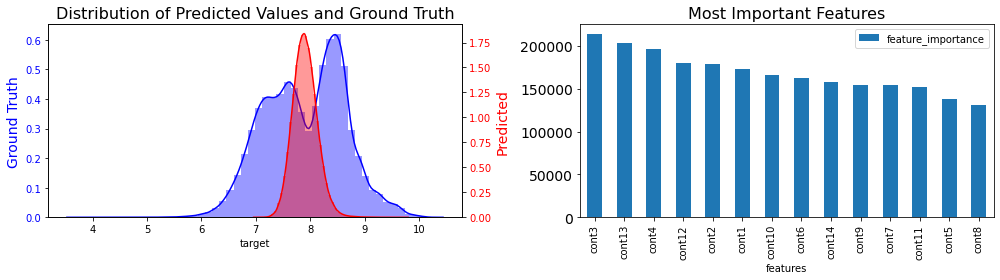

In [17]:
y_pred = lightgbm_run_model(X, 
                            y,
                            final_submission = True)

## Optuna LightGBM 

In [6]:
#==================================================================
#             Optuna - LightGBM In-Depth Search Example
#==================================================================
# No cross-validation used, faster evaluation.
# Includes pruning callback
# Parameter space defined

import numpy as np
import sklearn.datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Create train-test split
train_x, test_x, train_y, test_y = train_test_split(X[feature_cols], y, test_size=0.25, random_state=2021)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(test_x, label=test_y)

# Define our objective function
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        "verbose": 0,
        'learning_rate': trial.suggest_uniform('learning_rate', 1e-5, 0.5),      # IMPORTANT!                    
        'max_depth': trial.suggest_int('max_depth', 3, 25),                      # IMPORTANT! Typical: 6, usually [3, 12].
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),                   # IMPORTANT!
        'bagging_freq': trial.suggest_int('bagging_freq', 2, 100),               # Must set alongside bagging_fraction
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.0, 1.0), # IMPORTANT!
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.0, 1.0), # IMPORTANT
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),          # Regularization
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),          # Regularization
        #'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        #'min_split_gain' : trial.suggest_uniform('min_split_gain', 0.001, 0.1),
        #'min_child_weight' : trial.suggest_uniform('min_child_weight', 10, 50),
        #'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 1, 100),  # Recommended to lower that value for small datasets (like 100 observations), and to increase it (if needed) on large datasets.
        'feature_pre_filter': trial.suggest_categorical('feature_pre_filter', [True, False]),
        #'max_bin' : trial.suggest_int('max_bin', 32, 512), 
    }
    # Set up pruning callback
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    # Instantiate model with callback and valid set
    gbm = lgb.train(param, 
                    dtrain, 
                    num_boost_round=500,
                    valid_sets=dval, 
                    callbacks=[pruning_callback],
                    verbose_eval = False,
                   )
    # Predict and get metric to return for optimization
    preds = gbm.predict(test_x)
    pred_labels = np.rint(preds)
    rmse = sklearn.metrics.mean_squared_error(test_y, pred_labels, squared = False)
    return rmse
 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-01-18 21:04:37,474] A new study created in memory with name: no-name-92226033-f5fa-4b86-9669-11211b1d93c2
[I 2021-01-18 21:04:50,539] Trial 0 finished with value: 0.8244871082027333 and parameters: {'learning_rate': 0.4947592144933563, 'max_depth': 23, 'num_leaves': 63, 'bagging_freq': 6, 'bagging_fraction': 0.6047255914567989, 'feature_fraction': 0.9843294068664893, 'lambda_l1': 0.0001233702521325605, 'lambda_l2': 1.3631730374239175, 'feature_pre_filter': True}. Best is trial 0 with value: 0.8244871082027333.
[I 2021-01-18 21:05:07,824] Trial 1 finished with value: 0.7400775067750944 and parameters: {'learning_rate': 0.10219843759398534, 'max_depth': 8, 'num_leaves': 87, 'bagging_freq': 14, 'bagging_fraction': 0.7166086176113161, 'feature_fraction': 0.6496357453781016, 'lambda_l1': 0.3711190531790285, 'lambda_l2': 7.200718147307973e-05, 'feature_pre_filter': True}. Best is trial 1 with value: 0.7400775067750944.
[I 2021-01-18 21:05:26,455] Trial 2 finished with value: 0.807828

Number of finished trials: 100
Best trial: {'learning_rate': 0.1276831568412027, 'max_depth': 4, 'num_leaves': 458, 'bagging_freq': 49, 'bagging_fraction': 0.9575889402651221, 'feature_fraction': 0.6648020037366106, 'lambda_l1': 3.2289289377374766e-05, 'lambda_l2': 1.0852167374408492, 'feature_pre_filter': False}


In [7]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7372337205662389
  Params: 
    learning_rate: 0.1276831568412027
    max_depth: 4
    num_leaves: 458
    bagging_freq: 49
    bagging_fraction: 0.9575889402651221
    feature_fraction: 0.6648020037366106
    lambda_l1: 3.2289289377374766e-05
    lambda_l2: 1.0852167374408492
    feature_pre_filter: False


## LightGBM Tuner

https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258

LightGBM Tuner achieved better evaluation results on 6 of the 9 datasets.
The current implementation of LightGBM Tuner fixes the order of the tuning variables and the number of trials for each variable. By searching for hyperparameters that have a large effect and tuning them in the ideal order, further improvements may be possible.

In [8]:
#==================================================================
#             Optuna - LightGBM Tuner Simple Example
#==================================================================
# import optuna.integration.lightgbm as lgb
# We don't need to define any search space as the tuner automatically tunes certain hyperparameters in a specific order
# feature_fraction -> num_leaves -> bagging_fraction -> feature_fraction -> lambda_l1 -> min_child_samples
# https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258

# No cross-validation used, faster evaluation on a single fold.
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import train_test_split

# We aren't using an in-built cv method, so lets define a train/test split
train_x, test_x, train_y, test_y = train_test_split(X[feature_cols], y, test_size=0.1, random_state=2021)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(test_x, label=test_y)

# Define key parameters for our model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    "verbosity": 0,
    "boosting_type": "gbdt",
}

# Instantiate the lgb tuner - we don't need to define any search space as the tuner automatically tunes certain hyperparameters in a specific order
model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dval],    # Pass in validation sets for early stopping to work
                  verbose_eval=False, 
                  early_stopping_rounds=100,
                  show_progress_bar = True
                 )

[I 2021-01-18 21:14:28,048] A new study created in memory with name: no-name-1a31a6dd-3605-4e39-bf65-812e81fa582e
min_data_in_leaf, val_score: 0.696296: 100%|##########| 5/5 [01:47<00:00, 21.48s/it]


In [9]:
# Get metric for the given fold
prediction = model.predict(test_x, num_iteration=model.best_iteration)
accuracy = mean_squared_error(test_y, prediction, squared=False)
best_params = model.params
best_iteration = model.best_iteration

print("Best params:", best_params)
print("Accuracy = {}".format(accuracy))
print("Best Iteration = {}".format(best_iteration))
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best params: {'objective': 'regression', 'metric': 'rmse', 'verbosity': 0, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 9.868479064299967, 'lambda_l2': 4.063453998434796e-06, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 100}
Accuracy = 0.6962961901318865
Best Iteration = 1000
Params: 
    objective: regression
    metric: rmse
    verbosity: 0
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 9.868479064299967
    lambda_l2: 4.063453998434796e-06
    num_leaves: 31
    feature_fraction: 0.7
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 100


## LightGBM Tuner with CV

In [10]:
#==================================================================
#                  Optuna - LightGBM Tuner with CV
#==================================================================
# import optuna.integration.lightgbm as lgb
# We don't need to define any search space as the tuner automatically tunes certain hyperparameters in a specific order
# https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258

from sklearn.model_selection import KFold
import optuna.integration.lightgbm as lgb

# Set up lgb.Dataset
dtrain = lgb.Dataset(X, label=y)

# Define key parameters for this specific dataset
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": 0,
    "boosting_type": "gbdt",
}

# Instantiate LightGBMTunerCV - we don't need to define any search space as the tuner automatically tunes certain hyperparameters in a specific order
tuner = lgb.LightGBMTunerCV(params, 
                            dtrain, 
                            verbose_eval=100, 
                            early_stopping_rounds=50, 
                            folds = KFold(n_splits=5, shuffle = True, random_state=2021),
                            show_progress_bar=False,
                           )

tuner.run()

[I 2021-01-18 21:31:54,487] A new study created in memory with name: no-name-87c5c4c4-98c3-4909-aa38-2bec2dda21f7


[100]	cv_agg's rmse: 0.702463 + 0.00192611
[200]	cv_agg's rmse: 0.700569 + 0.00197844
[300]	cv_agg's rmse: 0.699913 + 0.00198637
[400]	cv_agg's rmse: 0.699616 + 0.00198516
[500]	cv_agg's rmse: 0.699483 + 0.00202959


[I 2021-01-18 21:32:40,389] Trial 0 finished with value: 0.6994749800937041 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.6994749800937041.


[100]	cv_agg's rmse: 0.702554 + 0.00211192
[200]	cv_agg's rmse: 0.700348 + 0.00200971
[300]	cv_agg's rmse: 0.699664 + 0.00205035
[400]	cv_agg's rmse: 0.699343 + 0.0020658
[500]	cv_agg's rmse: 0.699167 + 0.00210264
[600]	cv_agg's rmse: 0.699099 + 0.00204509


[I 2021-01-18 21:33:15,822] Trial 1 finished with value: 0.6990965595006513 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.6990965595006513.


[100]	cv_agg's rmse: 0.702346 + 0.0020102
[200]	cv_agg's rmse: 0.700432 + 0.00201363
[300]	cv_agg's rmse: 0.699783 + 0.00203874
[400]	cv_agg's rmse: 0.699422 + 0.00195263
[500]	cv_agg's rmse: 0.699273 + 0.00201779


[I 2021-01-18 21:33:50,581] Trial 2 finished with value: 0.6992582437709267 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.6990965595006513.


[100]	cv_agg's rmse: 0.7024 + 0.00197455
[200]	cv_agg's rmse: 0.700486 + 0.00192771
[300]	cv_agg's rmse: 0.699828 + 0.00197996
[400]	cv_agg's rmse: 0.699473 + 0.001981
[500]	cv_agg's rmse: 0.699345 + 0.00193259
[600]	cv_agg's rmse: 0.699289 + 0.00188922
[700]	cv_agg's rmse: 0.699308 + 0.00195342


[I 2021-01-18 21:34:40,995] Trial 3 finished with value: 0.6992480776722786 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.6990965595006513.


[100]	cv_agg's rmse: 0.702312 + 0.00196848
[200]	cv_agg's rmse: 0.70039 + 0.00188192
[300]	cv_agg's rmse: 0.699688 + 0.00193699
[400]	cv_agg's rmse: 0.699368 + 0.00190274
[500]	cv_agg's rmse: 0.699171 + 0.00189139
[600]	cv_agg's rmse: 0.699048 + 0.00184732


[I 2021-01-18 21:35:24,115] Trial 4 finished with value: 0.6990103632987458 and parameters: {'feature_fraction': 0.7}. Best is trial 4 with value: 0.6990103632987458.


[100]	cv_agg's rmse: 0.70232 + 0.00204866
[200]	cv_agg's rmse: 0.700423 + 0.00200419
[300]	cv_agg's rmse: 0.69965 + 0.00202746
[400]	cv_agg's rmse: 0.699264 + 0.00208107
[500]	cv_agg's rmse: 0.699057 + 0.00206865
[600]	cv_agg's rmse: 0.699009 + 0.00200349


[I 2021-01-18 21:36:02,474] Trial 5 finished with value: 0.6989898057533479 and parameters: {'feature_fraction': 0.5}. Best is trial 5 with value: 0.6989898057533479.


[100]	cv_agg's rmse: 0.70237 + 0.00195232
[200]	cv_agg's rmse: 0.700625 + 0.00200168
[300]	cv_agg's rmse: 0.699918 + 0.00206858
[400]	cv_agg's rmse: 0.699612 + 0.00203799
[500]	cv_agg's rmse: 0.699435 + 0.00209045


[I 2021-01-18 21:36:45,048] Trial 6 finished with value: 0.6994343924988209 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with value: 0.6989898057533479.


[100]	cv_agg's rmse: 0.699825 + 0.00178561
[200]	cv_agg's rmse: 0.699075 + 0.00179024


[I 2021-01-18 21:37:11,717] Trial 7 finished with value: 0.6990677895625664 and parameters: {'num_leaves': 85}. Best is trial 7 with value: 0.6990677895625664.


[100]	cv_agg's rmse: 0.710746 + 0.00200066
[200]	cv_agg's rmse: 0.706815 + 0.00196537
[300]	cv_agg's rmse: 0.704869 + 0.00195147
[400]	cv_agg's rmse: 0.703639 + 0.00193747
[500]	cv_agg's rmse: 0.702723 + 0.00194599
[600]	cv_agg's rmse: 0.70206 + 0.00197034
[700]	cv_agg's rmse: 0.701502 + 0.00195505
[800]	cv_agg's rmse: 0.701094 + 0.0019564
[900]	cv_agg's rmse: 0.700771 + 0.00197093


[I 2021-01-18 21:37:53,199] Trial 8 finished with value: 0.7004743213861867 and parameters: {'num_leaves': 7}. Best is trial 7 with value: 0.6990677895625664.


[1000]	cv_agg's rmse: 0.700474 + 0.00195197
[100]	cv_agg's rmse: 0.699463 + 0.00206213


[I 2021-01-18 21:38:20,773] Trial 9 finished with value: 0.6993121645769074 and parameters: {'num_leaves': 201}. Best is trial 7 with value: 0.6990677895625664.


[100]	cv_agg's rmse: 0.699276 + 0.00213


[I 2021-01-18 21:38:50,033] Trial 10 finished with value: 0.6992571391634748 and parameters: {'num_leaves': 236}. Best is trial 7 with value: 0.6990677895625664.


[100]	cv_agg's rmse: 0.699382 + 0.00195688


[I 2021-01-18 21:39:18,021] Trial 11 finished with value: 0.6992316881006146 and parameters: {'num_leaves': 170}. Best is trial 7 with value: 0.6990677895625664.


[100]	cv_agg's rmse: 0.699681 + 0.00194513
[200]	cv_agg's rmse: 0.699309 + 0.00193863


[I 2021-01-18 21:39:46,240] Trial 12 finished with value: 0.6993055034652118 and parameters: {'num_leaves': 110}. Best is trial 7 with value: 0.6990677895625664.


[100]	cv_agg's rmse: 0.699743 + 0.00190724
[200]	cv_agg's rmse: 0.699122 + 0.00193472


[I 2021-01-18 21:40:15,562] Trial 13 finished with value: 0.6990743690878196 and parameters: {'num_leaves': 94}. Best is trial 7 with value: 0.6990677895625664.


[100]	cv_agg's rmse: 0.70053 + 0.00197466
[200]	cv_agg's rmse: 0.699363 + 0.00204362
[300]	cv_agg's rmse: 0.699027 + 0.0019597


[I 2021-01-18 21:40:44,558] Trial 14 finished with value: 0.6990176162951671 and parameters: {'num_leaves': 59}. Best is trial 14 with value: 0.6990176162951671.


[100]	cv_agg's rmse: 0.699334 + 0.00198907
[200]	cv_agg's rmse: 0.699194 + 0.00207375


[I 2021-01-18 21:41:12,219] Trial 15 finished with value: 0.6990354685814049 and parameters: {'num_leaves': 140}. Best is trial 14 with value: 0.6990176162951671.


[100]	cv_agg's rmse: 0.701088 + 0.00193475
[200]	cv_agg's rmse: 0.699752 + 0.00190841
[300]	cv_agg's rmse: 0.699353 + 0.00191199
[400]	cv_agg's rmse: 0.699196 + 0.00182876


[I 2021-01-18 21:41:46,418] Trial 16 finished with value: 0.699137306344872 and parameters: {'num_leaves': 48}. Best is trial 14 with value: 0.6990176162951671.


[100]	cv_agg's rmse: 0.717691 + 0.00198382
[200]	cv_agg's rmse: 0.714212 + 0.00202447
[300]	cv_agg's rmse: 0.712149 + 0.00198348
[400]	cv_agg's rmse: 0.710685 + 0.0019799
[500]	cv_agg's rmse: 0.709541 + 0.00198056
[600]	cv_agg's rmse: 0.708619 + 0.0019915
[700]	cv_agg's rmse: 0.707844 + 0.00201262
[800]	cv_agg's rmse: 0.707226 + 0.00201641
[900]	cv_agg's rmse: 0.70664 + 0.00202896


[I 2021-01-18 21:42:19,529] Trial 17 finished with value: 0.7061773659484141 and parameters: {'num_leaves': 3}. Best is trial 14 with value: 0.6990176162951671.


[1000]	cv_agg's rmse: 0.706177 + 0.00203947
[100]	cv_agg's rmse: 0.69946 + 0.00193251
[200]	cv_agg's rmse: 0.699476 + 0.00192868


[I 2021-01-18 21:42:47,086] Trial 18 finished with value: 0.6992430849852787 and parameters: {'num_leaves': 144}. Best is trial 14 with value: 0.6990176162951671.


[100]	cv_agg's rmse: 0.700466 + 0.00218898
[200]	cv_agg's rmse: 0.699351 + 0.00216413
[300]	cv_agg's rmse: 0.699094 + 0.00211101
[400]	cv_agg's rmse: 0.699088 + 0.0020611


[I 2021-01-18 21:43:20,060] Trial 19 finished with value: 0.6990616259008112 and parameters: {'num_leaves': 58}. Best is trial 14 with value: 0.6990176162951671.


[100]	cv_agg's rmse: 0.69946 + 0.00193251
[200]	cv_agg's rmse: 0.699476 + 0.00192868


[I 2021-01-18 21:43:47,337] Trial 20 finished with value: 0.6992430849852787 and parameters: {'num_leaves': 144}. Best is trial 14 with value: 0.6990176162951671.


[100]	cv_agg's rmse: 0.700911 + 0.00196295
[200]	cv_agg's rmse: 0.699606 + 0.00192765
[300]	cv_agg's rmse: 0.699181 + 0.00194163
[400]	cv_agg's rmse: 0.699091 + 0.00192732


[I 2021-01-18 21:44:20,736] Trial 21 finished with value: 0.6990508112432708 and parameters: {'num_leaves': 50}. Best is trial 14 with value: 0.6990176162951671.


[100]	cv_agg's rmse: 0.699415 + 0.00207307


[I 2021-01-18 21:44:46,048] Trial 22 finished with value: 0.6993475985213615 and parameters: {'num_leaves': 177}. Best is trial 14 with value: 0.6990176162951671.


[100]	cv_agg's rmse: 0.699563 + 0.00188438
[200]	cv_agg's rmse: 0.699087 + 0.00189183


[I 2021-01-18 21:45:14,861] Trial 23 finished with value: 0.69907598746612 and parameters: {'num_leaves': 122}. Best is trial 14 with value: 0.6990176162951671.


[100]	cv_agg's rmse: 0.700136 + 0.00204812
[200]	cv_agg's rmse: 0.699207 + 0.00194815
[300]	cv_agg's rmse: 0.699061 + 0.0019979


[I 2021-01-18 21:45:46,352] Trial 24 finished with value: 0.6990341642166051 and parameters: {'num_leaves': 75}. Best is trial 14 with value: 0.6990176162951671.


[100]	cv_agg's rmse: 0.702922 + 0.00202152
[200]	cv_agg's rmse: 0.700683 + 0.00202035
[300]	cv_agg's rmse: 0.699843 + 0.00206401
[400]	cv_agg's rmse: 0.69945 + 0.00197231
[500]	cv_agg's rmse: 0.699195 + 0.00197447
[600]	cv_agg's rmse: 0.699123 + 0.00202613
[700]	cv_agg's rmse: 0.699029 + 0.00203184


[I 2021-01-18 21:46:30,177] Trial 25 finished with value: 0.6989609871550388 and parameters: {'num_leaves': 26}. Best is trial 25 with value: 0.6989609871550388.


[800]	cv_agg's rmse: 0.698977 + 0.00213257
[100]	cv_agg's rmse: 0.705384 + 0.00195551
[200]	cv_agg's rmse: 0.702358 + 0.00189584
[300]	cv_agg's rmse: 0.701163 + 0.00199029
[400]	cv_agg's rmse: 0.700494 + 0.00199113
[500]	cv_agg's rmse: 0.700021 + 0.00202731
[600]	cv_agg's rmse: 0.699638 + 0.0020216
[700]	cv_agg's rmse: 0.6994 + 0.00207003
[800]	cv_agg's rmse: 0.699233 + 0.00206139
[900]	cv_agg's rmse: 0.699108 + 0.00204597


[I 2021-01-18 21:47:17,721] Trial 26 finished with value: 0.6990128075580216 and parameters: {'num_leaves': 16}. Best is trial 25 with value: 0.6989609871550388.


[1000]	cv_agg's rmse: 0.699023 + 0.00203313
[100]	cv_agg's rmse: 0.703127 + 0.00199802
[200]	cv_agg's rmse: 0.70079 + 0.00202371
[300]	cv_agg's rmse: 0.699931 + 0.00203348
[400]	cv_agg's rmse: 0.699595 + 0.00202832
[500]	cv_agg's rmse: 0.699494 + 0.0021075


[I 2021-01-18 21:48:04,635] Trial 27 finished with value: 0.6994647699148696 and parameters: {'bagging_fraction': 0.7004149593207751, 'bagging_freq': 4}. Best is trial 27 with value: 0.6994647699148696.


[100]	cv_agg's rmse: 0.703307 + 0.00180365
[200]	cv_agg's rmse: 0.701039 + 0.00197048
[300]	cv_agg's rmse: 0.700116 + 0.00209843
[400]	cv_agg's rmse: 0.699803 + 0.00209084
[500]	cv_agg's rmse: 0.699669 + 0.00198905
[600]	cv_agg's rmse: 0.699612 + 0.00191406


[I 2021-01-18 21:48:59,452] Trial 28 finished with value: 0.6995751861740587 and parameters: {'bagging_fraction': 0.7010223012828721, 'bagging_freq': 7}. Best is trial 27 with value: 0.6994647699148696.


[100]	cv_agg's rmse: 0.703207 + 0.00182769
[200]	cv_agg's rmse: 0.700998 + 0.00194167
[300]	cv_agg's rmse: 0.700131 + 0.00200869
[400]	cv_agg's rmse: 0.699852 + 0.00202573
[500]	cv_agg's rmse: 0.699669 + 0.00195457
[600]	cv_agg's rmse: 0.69956 + 0.00203494
[700]	cv_agg's rmse: 0.699565 + 0.00203392


[I 2021-01-18 21:49:56,737] Trial 29 finished with value: 0.6995236529873982 and parameters: {'bagging_fraction': 0.6446252990541723, 'bagging_freq': 7}. Best is trial 27 with value: 0.6994647699148696.


[100]	cv_agg's rmse: 0.703239 + 0.00194412
[200]	cv_agg's rmse: 0.700974 + 0.00194498
[300]	cv_agg's rmse: 0.700236 + 0.00201884
[400]	cv_agg's rmse: 0.700003 + 0.00207299


[I 2021-01-18 21:50:38,991] Trial 30 finished with value: 0.6999178692002149 and parameters: {'bagging_fraction': 0.5609019528726489, 'bagging_freq': 5}. Best is trial 27 with value: 0.6994647699148696.


[100]	cv_agg's rmse: 0.703003 + 0.00186884
[200]	cv_agg's rmse: 0.700812 + 0.00187092
[300]	cv_agg's rmse: 0.69995 + 0.00182568
[400]	cv_agg's rmse: 0.699502 + 0.00185763
[500]	cv_agg's rmse: 0.69928 + 0.00187591
[600]	cv_agg's rmse: 0.699127 + 0.00190524
[700]	cv_agg's rmse: 0.699059 + 0.00195096


[I 2021-01-18 21:51:24,947] Trial 31 finished with value: 0.6990317843949598 and parameters: {'bagging_fraction': 0.9803714959212698, 'bagging_freq': 1}. Best is trial 31 with value: 0.6990317843949598.


[100]	cv_agg's rmse: 0.703244 + 0.00204546
[200]	cv_agg's rmse: 0.700809 + 0.0020605
[300]	cv_agg's rmse: 0.700066 + 0.00206432
[400]	cv_agg's rmse: 0.699711 + 0.00206763
[500]	cv_agg's rmse: 0.699587 + 0.00214794
[600]	cv_agg's rmse: 0.699529 + 0.00208282


[I 2021-01-18 21:52:08,701] Trial 32 finished with value: 0.6995095688613396 and parameters: {'bagging_fraction': 0.6964366840336604, 'bagging_freq': 1}. Best is trial 31 with value: 0.6990317843949598.


[100]	cv_agg's rmse: 0.703282 + 0.00205582
[200]	cv_agg's rmse: 0.70095 + 0.00204085
[300]	cv_agg's rmse: 0.700201 + 0.00206607
[400]	cv_agg's rmse: 0.69995 + 0.00196594
[500]	cv_agg's rmse: 0.699807 + 0.00191046


[I 2021-01-18 21:52:50,683] Trial 33 finished with value: 0.6998070889955345 and parameters: {'bagging_fraction': 0.5661429314423942, 'bagging_freq': 1}. Best is trial 31 with value: 0.6990317843949598.


[100]	cv_agg's rmse: 0.703661 + 0.00192997
[200]	cv_agg's rmse: 0.701559 + 0.00190652
[300]	cv_agg's rmse: 0.700903 + 0.00183716
[400]	cv_agg's rmse: 0.700701 + 0.00199015


[I 2021-01-18 21:53:30,895] Trial 34 finished with value: 0.700651063482912 and parameters: {'bagging_fraction': 0.408848610447194, 'bagging_freq': 7}. Best is trial 31 with value: 0.6990317843949598.


[100]	cv_agg's rmse: 0.703131 + 0.00198675
[200]	cv_agg's rmse: 0.700811 + 0.002013
[300]	cv_agg's rmse: 0.699955 + 0.00205942
[400]	cv_agg's rmse: 0.699566 + 0.00204321
[500]	cv_agg's rmse: 0.699431 + 0.00200255
[600]	cv_agg's rmse: 0.699274 + 0.00202926
[700]	cv_agg's rmse: 0.699251 + 0.00205669


[I 2021-01-18 21:54:32,857] Trial 35 finished with value: 0.6992272122685007 and parameters: {'bagging_fraction': 0.7605761620934003, 'bagging_freq': 5}. Best is trial 31 with value: 0.6990317843949598.


[100]	cv_agg's rmse: 0.703123 + 0.00195538
[200]	cv_agg's rmse: 0.700875 + 0.00202012
[300]	cv_agg's rmse: 0.699949 + 0.00215438
[400]	cv_agg's rmse: 0.699551 + 0.00211174
[500]	cv_agg's rmse: 0.699434 + 0.0021632
[600]	cv_agg's rmse: 0.699318 + 0.00217982
[700]	cv_agg's rmse: 0.699281 + 0.00223884


[I 2021-01-18 21:55:45,510] Trial 36 finished with value: 0.6992674198780067 and parameters: {'bagging_fraction': 0.8107013876550808, 'bagging_freq': 2}. Best is trial 31 with value: 0.6990317843949598.


[100]	cv_agg's rmse: 0.703216 + 0.00205245
[200]	cv_agg's rmse: 0.700741 + 0.00209719
[300]	cv_agg's rmse: 0.699937 + 0.00208613
[400]	cv_agg's rmse: 0.699566 + 0.00208618
[500]	cv_agg's rmse: 0.699321 + 0.00207462
[600]	cv_agg's rmse: 0.69911 + 0.00209772
[700]	cv_agg's rmse: 0.698991 + 0.00202522


[I 2021-01-18 21:56:23,898] Trial 37 finished with value: 0.6989195480486596 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 0.6989195480486596.


[100]	cv_agg's rmse: 0.702922 + 0.00202152
[200]	cv_agg's rmse: 0.700683 + 0.00202035
[300]	cv_agg's rmse: 0.699843 + 0.00206401
[400]	cv_agg's rmse: 0.69945 + 0.00197231
[500]	cv_agg's rmse: 0.699195 + 0.00197447
[600]	cv_agg's rmse: 0.699123 + 0.00202613
[700]	cv_agg's rmse: 0.699029 + 0.00203184


[I 2021-01-18 21:57:07,359] Trial 38 finished with value: 0.6989609871550388 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 37 with value: 0.6989195480486596.


[800]	cv_agg's rmse: 0.698977 + 0.00213257
[100]	cv_agg's rmse: 0.702944 + 0.00190242
[200]	cv_agg's rmse: 0.700876 + 0.0018961
[300]	cv_agg's rmse: 0.700001 + 0.00197848
[400]	cv_agg's rmse: 0.699553 + 0.00194106
[500]	cv_agg's rmse: 0.699261 + 0.00194173
[600]	cv_agg's rmse: 0.699147 + 0.00192253
[700]	cv_agg's rmse: 0.699058 + 0.00196437


[I 2021-01-18 21:57:48,293] Trial 39 finished with value: 0.6990410169720362 and parameters: {'feature_fraction': 0.58}. Best is trial 37 with value: 0.6989195480486596.


[100]	cv_agg's rmse: 0.703009 + 0.00198146
[200]	cv_agg's rmse: 0.700806 + 0.00191174
[300]	cv_agg's rmse: 0.700055 + 0.00187369
[400]	cv_agg's rmse: 0.699604 + 0.00184668
[500]	cv_agg's rmse: 0.699377 + 0.00188546
[600]	cv_agg's rmse: 0.69929 + 0.0018555
[700]	cv_agg's rmse: 0.6992 + 0.00189743
[800]	cv_agg's rmse: 0.699166 + 0.00189662


[I 2021-01-18 21:58:30,196] Trial 40 finished with value: 0.6991413360071024 and parameters: {'feature_fraction': 0.484}. Best is trial 37 with value: 0.6989195480486596.


[100]	cv_agg's rmse: 0.702922 + 0.00202152
[200]	cv_agg's rmse: 0.700683 + 0.00202035
[300]	cv_agg's rmse: 0.699843 + 0.00206401
[400]	cv_agg's rmse: 0.69945 + 0.00197231
[500]	cv_agg's rmse: 0.699195 + 0.00197447
[600]	cv_agg's rmse: 0.699123 + 0.00202613
[700]	cv_agg's rmse: 0.699029 + 0.00203184


[I 2021-01-18 21:59:12,909] Trial 41 finished with value: 0.6989609871550388 and parameters: {'feature_fraction': 0.516}. Best is trial 37 with value: 0.6989195480486596.


[800]	cv_agg's rmse: 0.698977 + 0.00213257
[100]	cv_agg's rmse: 0.703009 + 0.00198146
[200]	cv_agg's rmse: 0.700806 + 0.00191174
[300]	cv_agg's rmse: 0.700055 + 0.00187369
[400]	cv_agg's rmse: 0.699604 + 0.00184668
[500]	cv_agg's rmse: 0.699377 + 0.00188546
[600]	cv_agg's rmse: 0.69929 + 0.0018555
[700]	cv_agg's rmse: 0.6992 + 0.00189743
[800]	cv_agg's rmse: 0.699166 + 0.00189662


[I 2021-01-18 21:59:54,746] Trial 42 finished with value: 0.6991413360071024 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 37 with value: 0.6989195480486596.


[100]	cv_agg's rmse: 0.70315 + 0.0020646
[200]	cv_agg's rmse: 0.70072 + 0.00213483
[300]	cv_agg's rmse: 0.699994 + 0.00212596
[400]	cv_agg's rmse: 0.699604 + 0.00211674
[500]	cv_agg's rmse: 0.699424 + 0.0020967
[600]	cv_agg's rmse: 0.699241 + 0.00205417
[700]	cv_agg's rmse: 0.699187 + 0.00203349
[800]	cv_agg's rmse: 0.69911 + 0.00203238


[I 2021-01-18 22:00:35,169] Trial 43 finished with value: 0.699108329446825 and parameters: {'lambda_l1': 5.242353152718051e-05, 'lambda_l2': 0.2770757407549276}. Best is trial 43 with value: 0.699108329446825.


[100]	cv_agg's rmse: 0.703216 + 0.00205245
[200]	cv_agg's rmse: 0.700741 + 0.00209719
[300]	cv_agg's rmse: 0.699937 + 0.00208613
[400]	cv_agg's rmse: 0.699566 + 0.00208618
[500]	cv_agg's rmse: 0.699321 + 0.00207462
[600]	cv_agg's rmse: 0.69911 + 0.00209772
[700]	cv_agg's rmse: 0.698991 + 0.00202522
[800]	cv_agg's rmse: 0.698912 + 0.00194204


[I 2021-01-18 22:01:14,899] Trial 44 finished with value: 0.6989005399958839 and parameters: {'lambda_l1': 3.786707633361155e-05, 'lambda_l2': 1.798993548125111e-05}. Best is trial 44 with value: 0.6989005399958839.


[100]	cv_agg's rmse: 0.703216 + 0.00205245
[200]	cv_agg's rmse: 0.700748 + 0.00210527
[300]	cv_agg's rmse: 0.699937 + 0.00208786
[400]	cv_agg's rmse: 0.699557 + 0.00204911
[500]	cv_agg's rmse: 0.699256 + 0.00203909
[600]	cv_agg's rmse: 0.699102 + 0.00204661
[700]	cv_agg's rmse: 0.699015 + 0.00201801


[I 2021-01-18 22:01:52,740] Trial 45 finished with value: 0.6989728193452255 and parameters: {'lambda_l1': 5.054953705690994e-05, 'lambda_l2': 0.0012162132029221915}. Best is trial 44 with value: 0.6989005399958839.


[100]	cv_agg's rmse: 0.703149 + 0.00214006
[200]	cv_agg's rmse: 0.700711 + 0.00209878
[300]	cv_agg's rmse: 0.699905 + 0.00210507
[400]	cv_agg's rmse: 0.699525 + 0.00213958
[500]	cv_agg's rmse: 0.699241 + 0.00213137
[600]	cv_agg's rmse: 0.699069 + 0.00213104
[700]	cv_agg's rmse: 0.698952 + 0.00209708


[I 2021-01-18 22:02:31,256] Trial 46 finished with value: 0.6989064036357587 and parameters: {'lambda_l1': 0.1579948147549779, 'lambda_l2': 1.2576871181834233e-08}. Best is trial 44 with value: 0.6989005399958839.


[100]	cv_agg's rmse: 0.703194 + 0.00203214
[200]	cv_agg's rmse: 0.700779 + 0.00213357
[300]	cv_agg's rmse: 0.699967 + 0.00219946
[400]	cv_agg's rmse: 0.69957 + 0.00213824
[500]	cv_agg's rmse: 0.699269 + 0.00216261
[600]	cv_agg's rmse: 0.699187 + 0.0021231


[I 2021-01-18 22:03:05,684] Trial 47 finished with value: 0.699139036190805 and parameters: {'lambda_l1': 5.003370803583212e-07, 'lambda_l2': 0.06487013516876644}. Best is trial 44 with value: 0.6989005399958839.


[100]	cv_agg's rmse: 0.703171 + 0.00217234
[200]	cv_agg's rmse: 0.700492 + 0.00210584
[300]	cv_agg's rmse: 0.699571 + 0.00208477
[400]	cv_agg's rmse: 0.69905 + 0.00207007
[500]	cv_agg's rmse: 0.698673 + 0.00203165
[600]	cv_agg's rmse: 0.698447 + 0.0020171
[700]	cv_agg's rmse: 0.698272 + 0.00202756
[800]	cv_agg's rmse: 0.698263 + 0.00199102


[I 2021-01-18 22:03:49,721] Trial 48 finished with value: 0.6982439436533016 and parameters: {'lambda_l1': 3.0211959224132214, 'lambda_l2': 0.1679069739905412}. Best is trial 48 with value: 0.6982439436533016.


[100]	cv_agg's rmse: 0.703154 + 0.00212956
[200]	cv_agg's rmse: 0.700774 + 0.00210716
[300]	cv_agg's rmse: 0.699913 + 0.00214428
[400]	cv_agg's rmse: 0.699531 + 0.0020686
[500]	cv_agg's rmse: 0.699269 + 0.00201479
[600]	cv_agg's rmse: 0.699126 + 0.00197657


[I 2021-01-18 22:04:24,997] Trial 49 finished with value: 0.6990630073999717 and parameters: {'lambda_l1': 0.04375728224619157, 'lambda_l2': 9.125577481068754e-06}. Best is trial 48 with value: 0.6982439436533016.


[100]	cv_agg's rmse: 0.703195 + 0.00203237
[200]	cv_agg's rmse: 0.700688 + 0.00210164
[300]	cv_agg's rmse: 0.699912 + 0.00219011
[400]	cv_agg's rmse: 0.699544 + 0.00222728
[500]	cv_agg's rmse: 0.699259 + 0.00225826
[600]	cv_agg's rmse: 0.699152 + 0.00224441
[700]	cv_agg's rmse: 0.69904 + 0.00217853
[800]	cv_agg's rmse: 0.698974 + 0.00215852


[I 2021-01-18 22:05:07,132] Trial 50 finished with value: 0.698911019772208 and parameters: {'lambda_l1': 1.5617223663778782e-07, 'lambda_l2': 0.04548586484343516}. Best is trial 48 with value: 0.6982439436533016.


[100]	cv_agg's rmse: 0.703216 + 0.00205245
[200]	cv_agg's rmse: 0.700741 + 0.00209719
[300]	cv_agg's rmse: 0.699937 + 0.00208613
[400]	cv_agg's rmse: 0.699566 + 0.00208618
[500]	cv_agg's rmse: 0.699321 + 0.00207462
[600]	cv_agg's rmse: 0.69911 + 0.00209772
[700]	cv_agg's rmse: 0.698991 + 0.00202522


[I 2021-01-18 22:05:45,632] Trial 51 finished with value: 0.6989195474790143 and parameters: {'lambda_l1': 2.4946715808537635e-05, 'lambda_l2': 9.562941788867446e-08}. Best is trial 48 with value: 0.6982439436533016.


[100]	cv_agg's rmse: 0.703199 + 0.00203273
[200]	cv_agg's rmse: 0.700694 + 0.00210633
[300]	cv_agg's rmse: 0.69994 + 0.0021361
[400]	cv_agg's rmse: 0.699575 + 0.00211555
[500]	cv_agg's rmse: 0.699296 + 0.00207506
[600]	cv_agg's rmse: 0.699164 + 0.00205625
[700]	cv_agg's rmse: 0.699056 + 0.00209926
[800]	cv_agg's rmse: 0.698991 + 0.00205543


[I 2021-01-18 22:06:27,180] Trial 52 finished with value: 0.6989495093876622 and parameters: {'lambda_l1': 0.0035854280485523, 'lambda_l2': 2.987057856016712e-07}. Best is trial 48 with value: 0.6982439436533016.


[100]	cv_agg's rmse: 0.703175 + 0.00207836
[200]	cv_agg's rmse: 0.700428 + 0.00205414
[300]	cv_agg's rmse: 0.699432 + 0.00201843
[400]	cv_agg's rmse: 0.698908 + 0.00201893
[500]	cv_agg's rmse: 0.698527 + 0.00202566
[600]	cv_agg's rmse: 0.698298 + 0.00198907
[700]	cv_agg's rmse: 0.698164 + 0.00199597
[800]	cv_agg's rmse: 0.698087 + 0.00200262
[900]	cv_agg's rmse: 0.698008 + 0.00199085


[I 2021-01-18 22:07:15,322] Trial 53 finished with value: 0.698005321778464 and parameters: {'lambda_l1': 3.8751669737888985, 'lambda_l2': 7.829094628793571}. Best is trial 53 with value: 0.698005321778464.


[100]	cv_agg's rmse: 0.703205 + 0.00205481
[200]	cv_agg's rmse: 0.700257 + 0.00202875
[300]	cv_agg's rmse: 0.699294 + 0.00212358
[400]	cv_agg's rmse: 0.69872 + 0.00215623
[500]	cv_agg's rmse: 0.698299 + 0.00213065
[600]	cv_agg's rmse: 0.698067 + 0.00213013
[700]	cv_agg's rmse: 0.697878 + 0.00214693
[800]	cv_agg's rmse: 0.697793 + 0.00216303
[900]	cv_agg's rmse: 0.697684 + 0.00221583


[I 2021-01-18 22:08:08,256] Trial 54 finished with value: 0.6976537822480327 and parameters: {'lambda_l1': 8.239765153768861, 'lambda_l2': 3.039815514891024}. Best is trial 54 with value: 0.6976537822480327.


[1000]	cv_agg's rmse: 0.69767 + 0.00224679
[100]	cv_agg's rmse: 0.703275 + 0.00205201
[200]	cv_agg's rmse: 0.700302 + 0.00202698
[300]	cv_agg's rmse: 0.69924 + 0.00200794
[400]	cv_agg's rmse: 0.698645 + 0.00202692
[500]	cv_agg's rmse: 0.698198 + 0.0019815
[600]	cv_agg's rmse: 0.697931 + 0.00200603
[700]	cv_agg's rmse: 0.697778 + 0.00198351
[800]	cv_agg's rmse: 0.697656 + 0.00201311


[I 2021-01-18 22:08:56,426] Trial 55 finished with value: 0.6976520919206693 and parameters: {'lambda_l1': 9.906214515275154, 'lambda_l2': 9.083244827937369}. Best is trial 55 with value: 0.6976520919206693.


[100]	cv_agg's rmse: 0.703285 + 0.00205571
[200]	cv_agg's rmse: 0.700287 + 0.00209879
[300]	cv_agg's rmse: 0.699225 + 0.00216549
[400]	cv_agg's rmse: 0.698634 + 0.00214516
[500]	cv_agg's rmse: 0.698172 + 0.00214847
[600]	cv_agg's rmse: 0.697959 + 0.00212867
[700]	cv_agg's rmse: 0.697767 + 0.00207529
[800]	cv_agg's rmse: 0.697693 + 0.00204758


[I 2021-01-18 22:09:43,374] Trial 56 finished with value: 0.6976857062463815 and parameters: {'lambda_l1': 8.238725512084073, 'lambda_l2': 8.749355033064827}. Best is trial 55 with value: 0.6976520919206693.


[100]	cv_agg's rmse: 0.703198 + 0.00207791
[200]	cv_agg's rmse: 0.700684 + 0.00208812
[300]	cv_agg's rmse: 0.699832 + 0.00209515
[400]	cv_agg's rmse: 0.699384 + 0.0020683
[500]	cv_agg's rmse: 0.699095 + 0.00201499
[600]	cv_agg's rmse: 0.698942 + 0.00201833
[700]	cv_agg's rmse: 0.698879 + 0.00201065
[800]	cv_agg's rmse: 0.698794 + 0.00201582


[I 2021-01-18 22:10:26,686] Trial 57 finished with value: 0.6987808275764659 and parameters: {'lambda_l1': 0.22554560157041065, 'lambda_l2': 3.3947575984523732}. Best is trial 55 with value: 0.6976520919206693.


[900]	cv_agg's rmse: 0.698808 + 0.00204293
[100]	cv_agg's rmse: 0.703194 + 0.00203236
[200]	cv_agg's rmse: 0.700674 + 0.00210171
[300]	cv_agg's rmse: 0.699947 + 0.00208645
[400]	cv_agg's rmse: 0.699491 + 0.00213779
[500]	cv_agg's rmse: 0.69922 + 0.00217241
[600]	cv_agg's rmse: 0.699111 + 0.00218975
[700]	cv_agg's rmse: 0.69903 + 0.00222084


[I 2021-01-18 22:11:02,726] Trial 58 finished with value: 0.6990247075108714 and parameters: {'lambda_l1': 0.003799369688703118, 'lambda_l2': 0.0031276136727429633}. Best is trial 55 with value: 0.6976520919206693.


[100]	cv_agg's rmse: 0.703089 + 0.00208141
[200]	cv_agg's rmse: 0.700613 + 0.00210291
[300]	cv_agg's rmse: 0.699826 + 0.00218558
[400]	cv_agg's rmse: 0.699439 + 0.0022044
[500]	cv_agg's rmse: 0.699078 + 0.00220907
[600]	cv_agg's rmse: 0.698936 + 0.00219472
[700]	cv_agg's rmse: 0.6988 + 0.00216181
[800]	cv_agg's rmse: 0.698695 + 0.00219703
[900]	cv_agg's rmse: 0.698675 + 0.00221785


[I 2021-01-18 22:11:47,099] Trial 59 finished with value: 0.6986539019956285 and parameters: {'lambda_l1': 0.9136560189421857, 'lambda_l2': 1.1214246140236737}. Best is trial 55 with value: 0.6976520919206693.


[100]	cv_agg's rmse: 0.703216 + 0.00205245
[200]	cv_agg's rmse: 0.700748 + 0.00210526
[300]	cv_agg's rmse: 0.699977 + 0.00209682
[400]	cv_agg's rmse: 0.699606 + 0.0020561
[500]	cv_agg's rmse: 0.699287 + 0.00205732
[600]	cv_agg's rmse: 0.699163 + 0.0020863
[700]	cv_agg's rmse: 0.699012 + 0.00206935


[I 2021-01-18 22:12:24,566] Trial 60 finished with value: 0.6989914657240182 and parameters: {'lambda_l1': 1.4260829746190425e-08, 'lambda_l2': 0.007080906712172516}. Best is trial 55 with value: 0.6976520919206693.


[100]	cv_agg's rmse: 0.703165 + 0.00203078
[200]	cv_agg's rmse: 0.70073 + 0.00206236
[300]	cv_agg's rmse: 0.699948 + 0.00218738
[400]	cv_agg's rmse: 0.699604 + 0.00219863
[500]	cv_agg's rmse: 0.699339 + 0.00215141
[600]	cv_agg's rmse: 0.699179 + 0.00212939
[700]	cv_agg's rmse: 0.699118 + 0.00216559
[800]	cv_agg's rmse: 0.699031 + 0.00210682


[I 2021-01-18 22:13:05,382] Trial 61 finished with value: 0.6990008457571453 and parameters: {'lambda_l1': 0.010947262614748945, 'lambda_l2': 0.00010957303585456213}. Best is trial 55 with value: 0.6976520919206693.


[100]	cv_agg's rmse: 0.703167 + 0.0020291
[200]	cv_agg's rmse: 0.700299 + 0.00212579
[300]	cv_agg's rmse: 0.699319 + 0.00209673
[400]	cv_agg's rmse: 0.69876 + 0.0020511
[500]	cv_agg's rmse: 0.69835 + 0.00204393
[600]	cv_agg's rmse: 0.698125 + 0.00202233
[700]	cv_agg's rmse: 0.697935 + 0.00199405
[800]	cv_agg's rmse: 0.697853 + 0.00198346
[900]	cv_agg's rmse: 0.697833 + 0.00195319


[I 2021-01-18 22:13:58,237] Trial 62 finished with value: 0.6977519168077333 and parameters: {'lambda_l1': 6.772923925656035, 'lambda_l2': 1.0749406509718094}. Best is trial 55 with value: 0.6976520919206693.


[1000]	cv_agg's rmse: 0.697771 + 0.0019338
[100]	cv_agg's rmse: 0.703275 + 0.00205201
[200]	cv_agg's rmse: 0.70028 + 0.00201864
[300]	cv_agg's rmse: 0.6992 + 0.00204535
[400]	cv_agg's rmse: 0.698566 + 0.00201335
[500]	cv_agg's rmse: 0.698118 + 0.00202568
[600]	cv_agg's rmse: 0.69784 + 0.00203819
[700]	cv_agg's rmse: 0.697636 + 0.00207185
[800]	cv_agg's rmse: 0.697529 + 0.00204074
[900]	cv_agg's rmse: 0.69752 + 0.00204855


[I 2021-01-18 22:14:53,626] Trial 63 finished with value: 0.6974673345114701 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.6974673345114701.


[1000]	cv_agg's rmse: 0.697472 + 0.00201349
[100]	cv_agg's rmse: 0.703191 + 0.00208545
[200]	cv_agg's rmse: 0.700167 + 0.00206621
[300]	cv_agg's rmse: 0.699076 + 0.00205033
[400]	cv_agg's rmse: 0.69852 + 0.00209486
[500]	cv_agg's rmse: 0.69809 + 0.00208114
[600]	cv_agg's rmse: 0.697772 + 0.00209826
[700]	cv_agg's rmse: 0.697598 + 0.00206596
[800]	cv_agg's rmse: 0.697532 + 0.00207378


[I 2021-01-18 22:15:40,853] Trial 64 finished with value: 0.697520073285405 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.6974673345114701.


[100]	cv_agg's rmse: 0.703274 + 0.00205186
[200]	cv_agg's rmse: 0.700208 + 0.00206224
[300]	cv_agg's rmse: 0.699149 + 0.00206345
[400]	cv_agg's rmse: 0.698557 + 0.00206983
[500]	cv_agg's rmse: 0.698123 + 0.00203024
[600]	cv_agg's rmse: 0.697829 + 0.00207315
[700]	cv_agg's rmse: 0.69765 + 0.00207221
[800]	cv_agg's rmse: 0.697535 + 0.00206145
[900]	cv_agg's rmse: 0.697499 + 0.00205567


[I 2021-01-18 22:16:36,301] Trial 65 finished with value: 0.6974459733476273 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.6974459733476273.


[1000]	cv_agg's rmse: 0.697453 + 0.00204848
[100]	cv_agg's rmse: 0.703275 + 0.00205201
[200]	cv_agg's rmse: 0.700277 + 0.00202497
[300]	cv_agg's rmse: 0.699213 + 0.00208625
[400]	cv_agg's rmse: 0.698585 + 0.0020906
[500]	cv_agg's rmse: 0.698144 + 0.00207504
[600]	cv_agg's rmse: 0.697908 + 0.00205359
[700]	cv_agg's rmse: 0.697689 + 0.00204319
[800]	cv_agg's rmse: 0.697634 + 0.00203388
[900]	cv_agg's rmse: 0.697547 + 0.0020252


[I 2021-01-18 22:17:31,648] Trial 66 finished with value: 0.6974990216820223 and parameters: {'min_child_samples': 25}. Best is trial 65 with value: 0.6974459733476273.


[1000]	cv_agg's rmse: 0.697501 + 0.00204457
[100]	cv_agg's rmse: 0.703275 + 0.00205201
[200]	cv_agg's rmse: 0.700272 + 0.00200848
[300]	cv_agg's rmse: 0.69924 + 0.00206285
[400]	cv_agg's rmse: 0.698628 + 0.00201896
[500]	cv_agg's rmse: 0.698223 + 0.00214089
[600]	cv_agg's rmse: 0.697914 + 0.00211389
[700]	cv_agg's rmse: 0.6977 + 0.00212518
[800]	cv_agg's rmse: 0.697603 + 0.00216233
[900]	cv_agg's rmse: 0.697554 + 0.00211297


[I 2021-01-18 22:18:26,167] Trial 67 finished with value: 0.6975045051324099 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 0.6974459733476273.


[1000]	cv_agg's rmse: 0.69751 + 0.00210088


In [11]:
print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.6974459733476273
Best params: {'objective': 'regression', 'metric': 'rmse', 'verbosity': 0, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 9.906214515275154, 'lambda_l2': 9.083244827937369, 'num_leaves': 26, 'feature_fraction': 0.42, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 50}
  Params: 
    objective: regression
    metric: rmse
    verbosity: 0
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 9.906214515275154
    lambda_l2: 9.083244827937369
    num_leaves: 26
    feature_fraction: 0.42
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 50
